# **Settings**

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import nltk
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

# ignore warnings
pd.options.mode.chained_assignment = None
plt.rcParams.update({'figure.max_open_warning': 0})
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

drive.mount('/content/drive')

# change the path of current working directory
os.chdir('/content/drive/My Drive/TEDe')

df = pd.read_csv(os.getcwd() + '/netflix_titles.csv')
df_2 = pd.read_csv(os.getcwd() + '/IMDb movies.csv')

# remove characters from values in title column
df.title = df.title.str.strip('\u200b')
df_2.title = df_2.title.str.strip('\u200b')


# Missing data handling

# select all numeric columns from dataframe
numeric_df = df.select_dtypes(exclude=[object])
numeric_columns = list(numeric_df.columns)
# replace any empty numeric value with the value that appears most often
for i in numeric_columns:
  df[i].fillna(df[i].mode()[0], inplace=True)
# remove rows that contain empty non-numeric cells
df = df.dropna()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-3291894906.py:25: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2 = pd.read_csv(os.getcwd() + '/IMDb movies.csv')
/tmp/ipython-input-3291894906.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[i].fillna(df[i].mode()[0], inplace=True)


# **Ερωτήματα**

## **Ερώτημα 1**



Type  counts
0    Movie    4673
1  TV Show     135

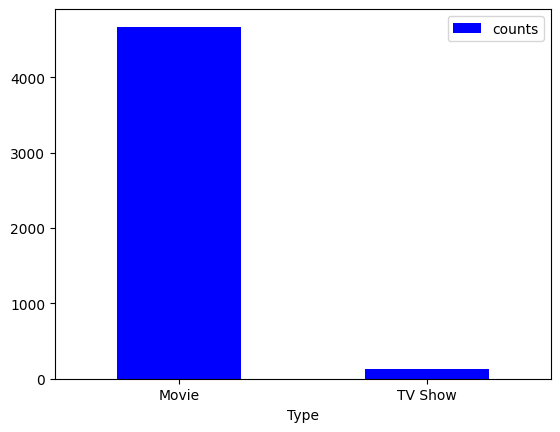

In [2]:
# from column 'type', count the number of values of each unique type
q1 = df['type'].explode().value_counts().rename_axis('Type').reset_index(name='counts')

# create plot
q1.plot.bar(x='Type', color='blue')
plt.xticks(rotation=360)

# print sorted value's array
q1.sort_values(by='counts', ascending=False, ignore_index=True)

## **Ερώτημα 2**

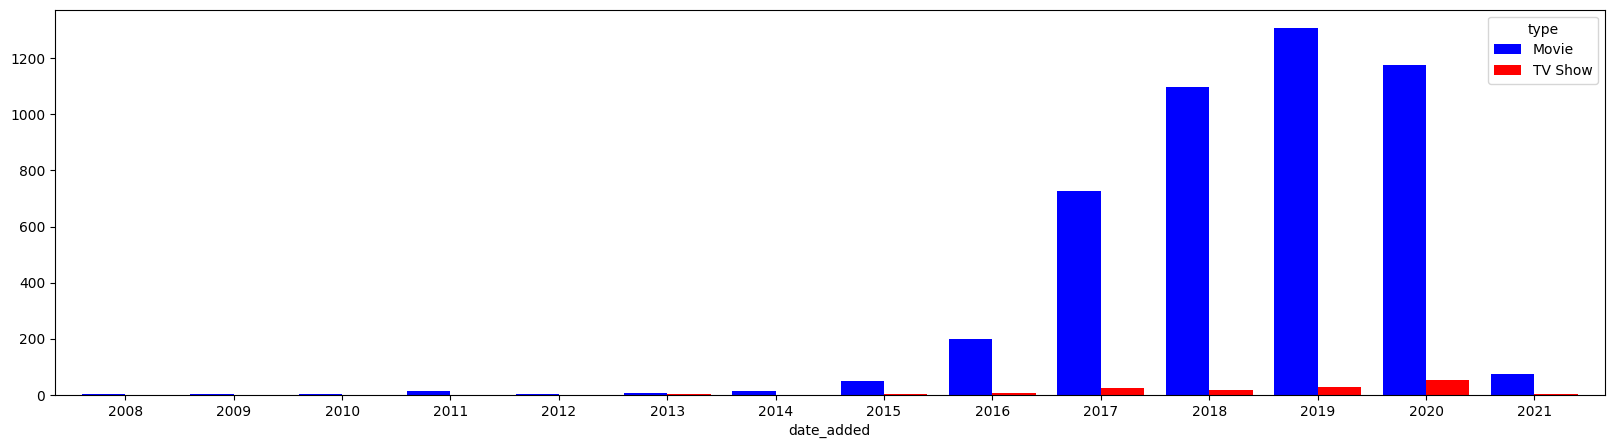

In [3]:
# create new dataframe that is group by type and has a column for the number of movies/tv shows of each date
q2 = df.groupby(['type', 'date_added']).size().reset_index(name='counts')

# split the date and take only the year out of it
q2['date_added'] = q2['date_added'].str.split(' ').str[-1]

# summarize the number of movies/tv shows by year
aggregation_functions = {'counts': 'sum'}
q2 = q2.groupby(['type', 'date_added']).aggregate(aggregation_functions).reset_index()

q2.pivot(index='date_added', columns='type', values='counts').plot.bar(figsize=(20, 5), width=0.8, color=['blue', 'red'])
plt.xticks(rotation=360);

## **Ερώτημα 3**

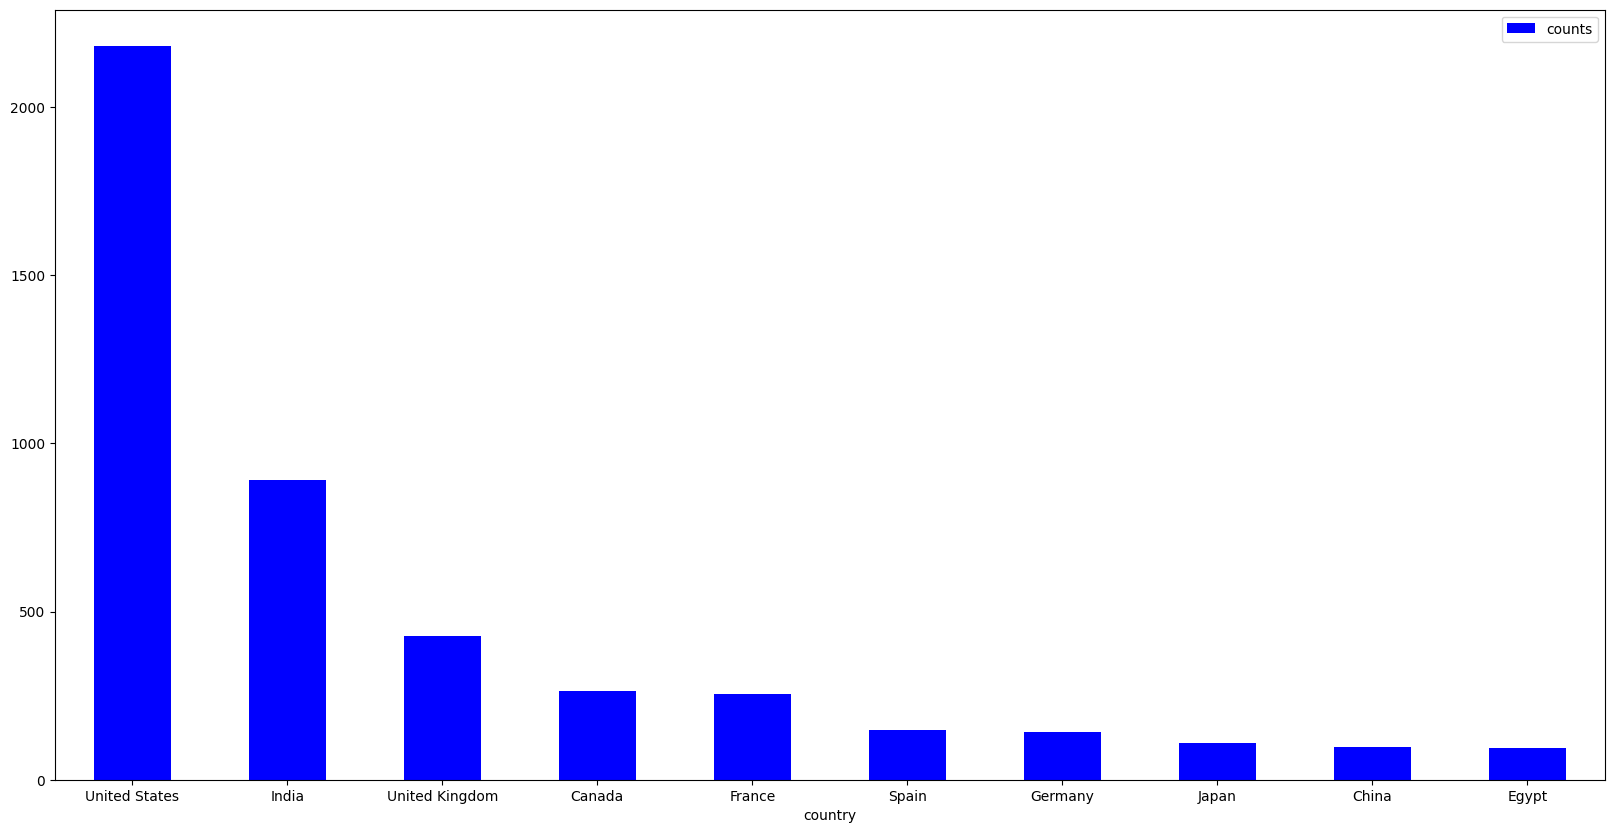

In [4]:
# split strings with multiple countries in the cells of column 'country' so that we can get idividual countries
q3 = df.set_index(['show_id', 'type', 'title', 'director', 'cast', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']) \
.apply(lambda x: x.str.split(', ').explode()).reset_index() \
.groupby('country').size().reset_index(name='counts')

# replace errors in data (some strings in column 'country' is not completed -they have ',' without something afterwards)
q3.country = q3.country.str.replace(',', '')

q3 = q3.sort_values(['counts'], ascending=False, ignore_index=True)
q3[:10].plot.bar(x='country', y='counts', figsize=(20, 10), color='blue')
plt.xticks(rotation=360);

## **Ερώτημα 4**

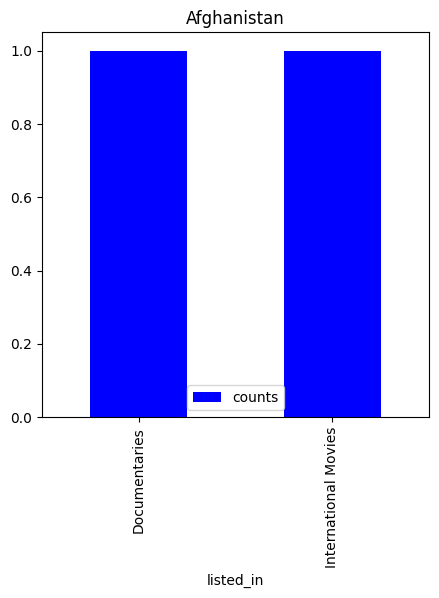

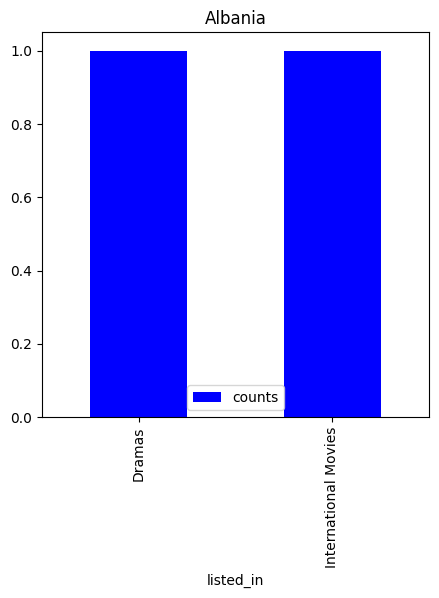

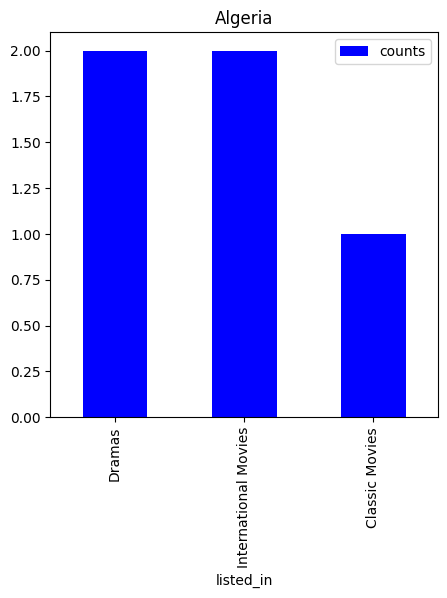

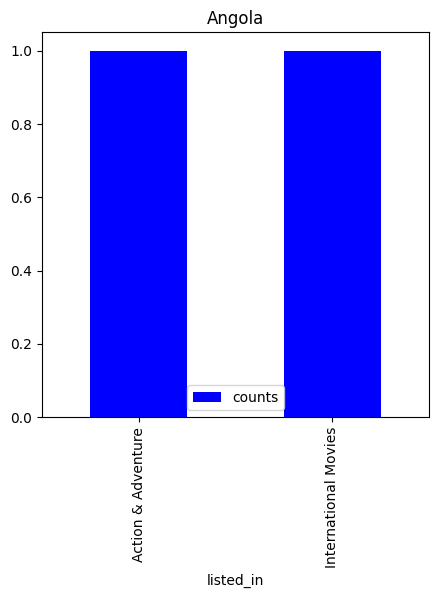

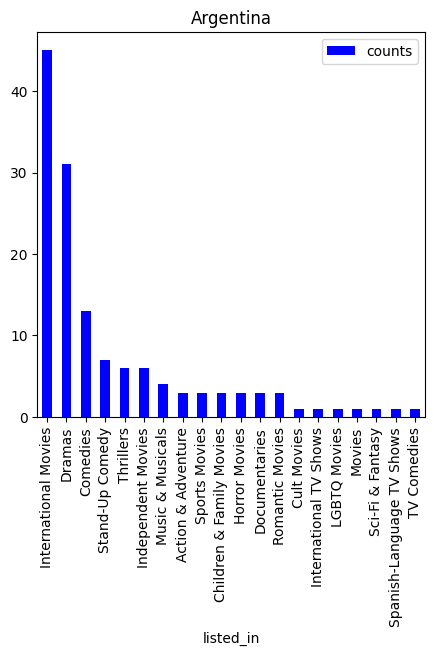

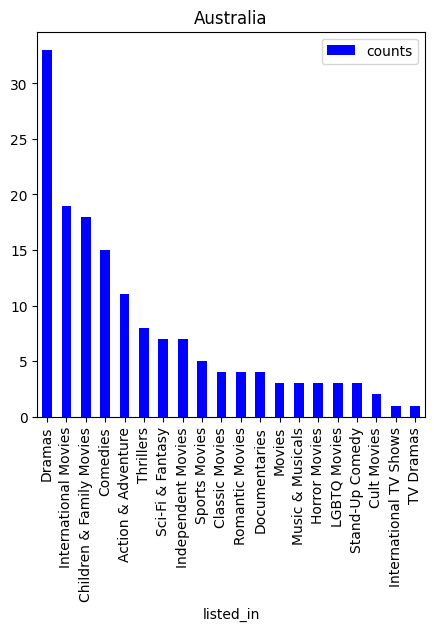

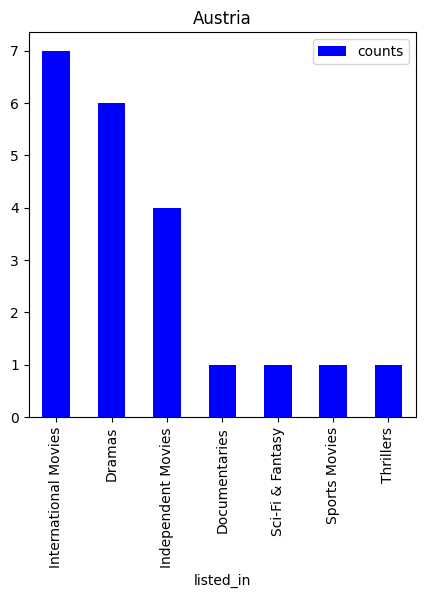

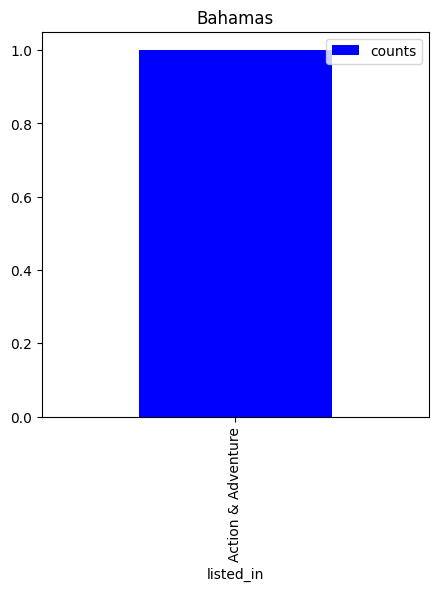

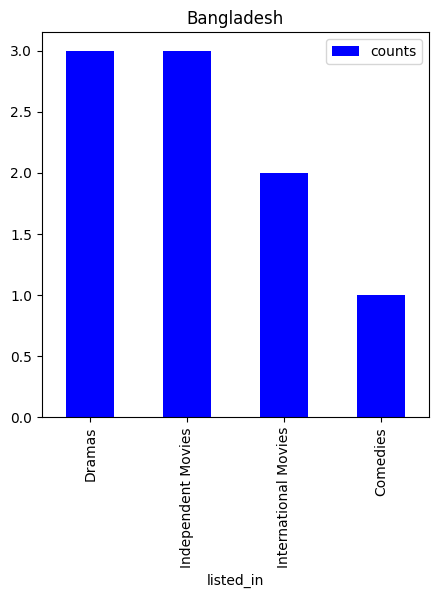

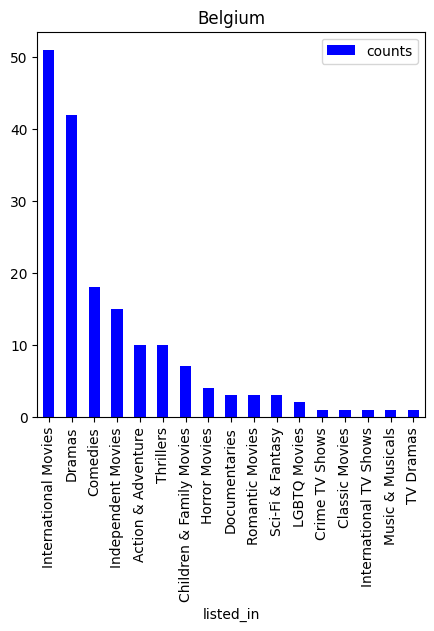

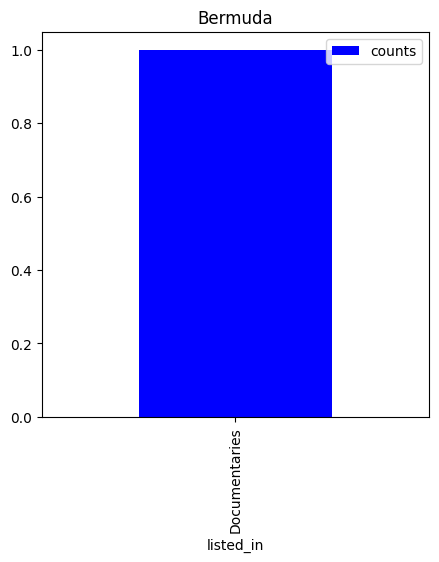

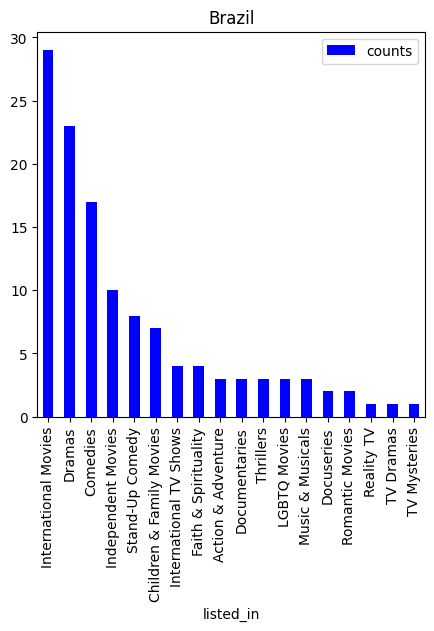

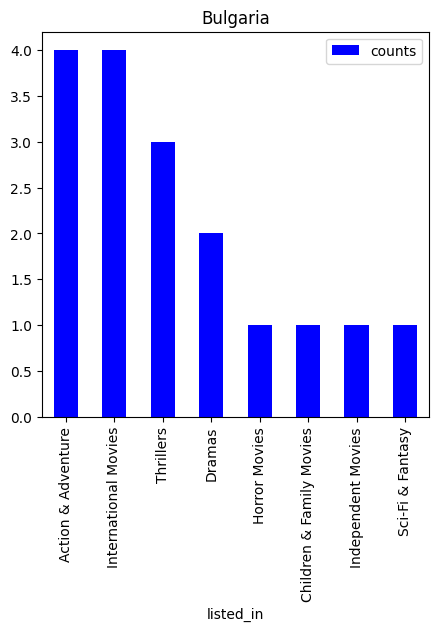

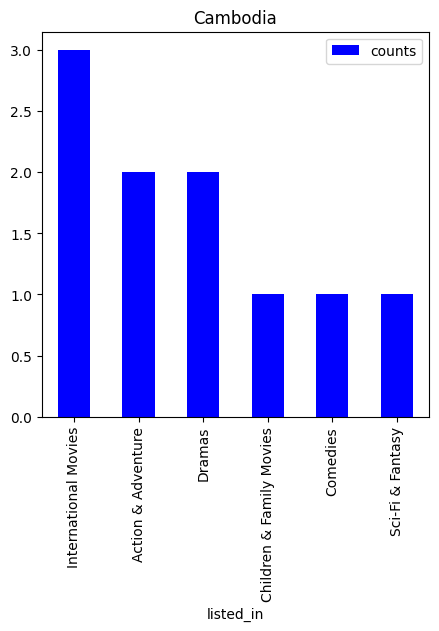

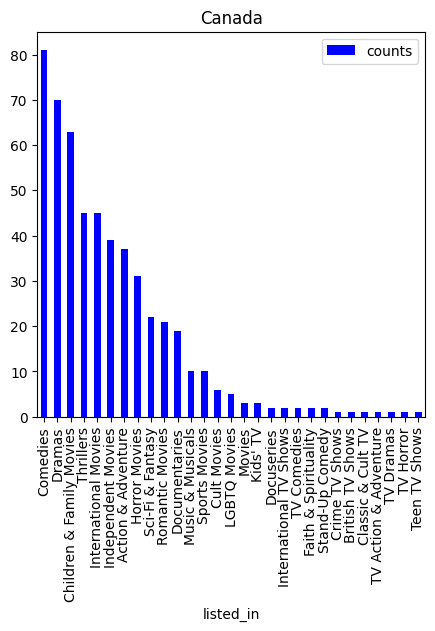

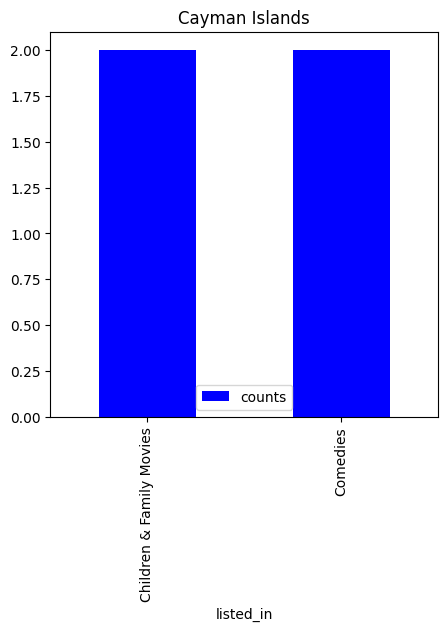

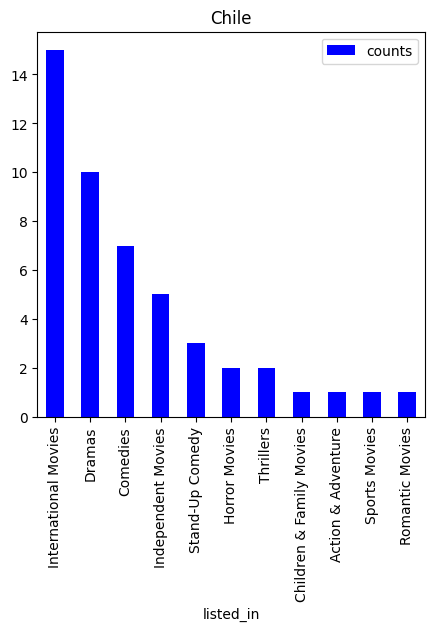

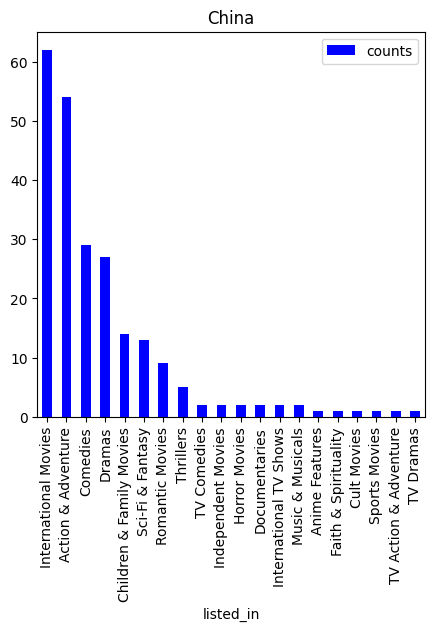

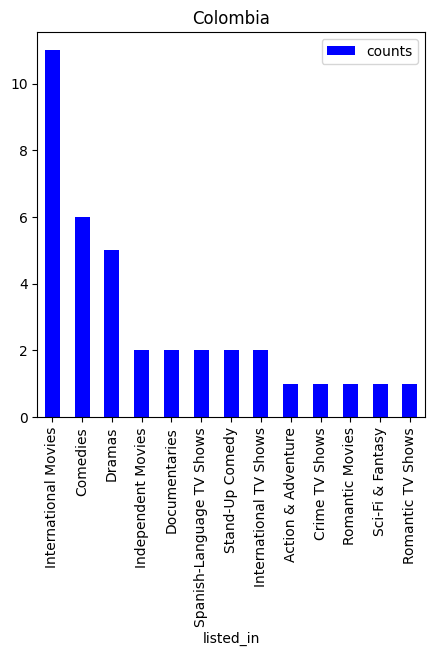

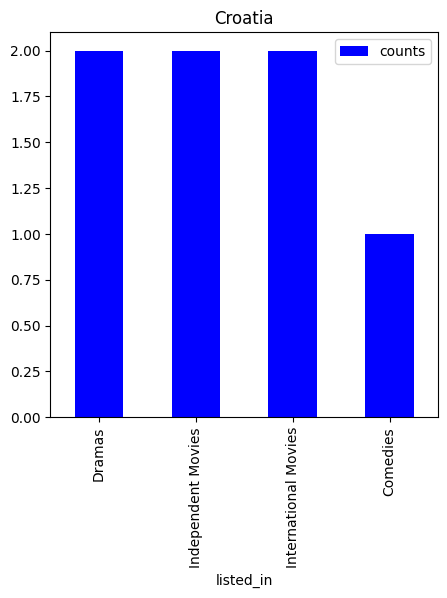

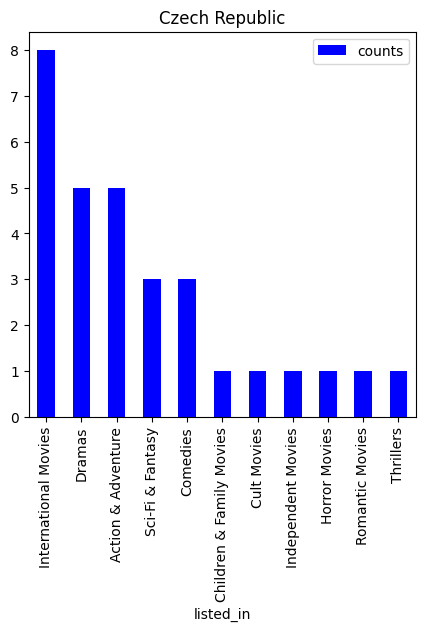

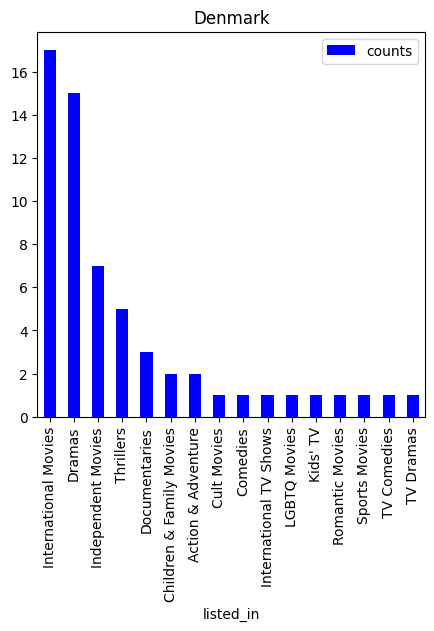

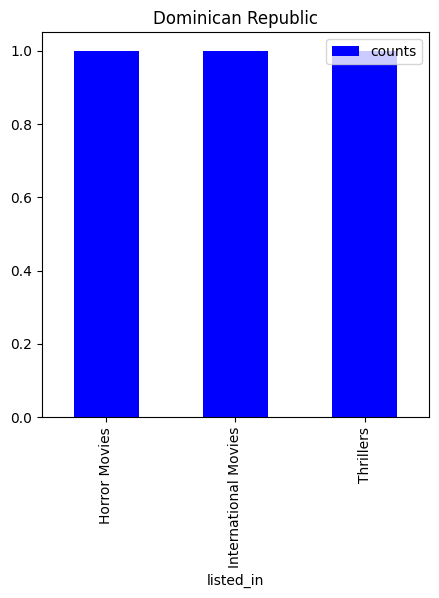

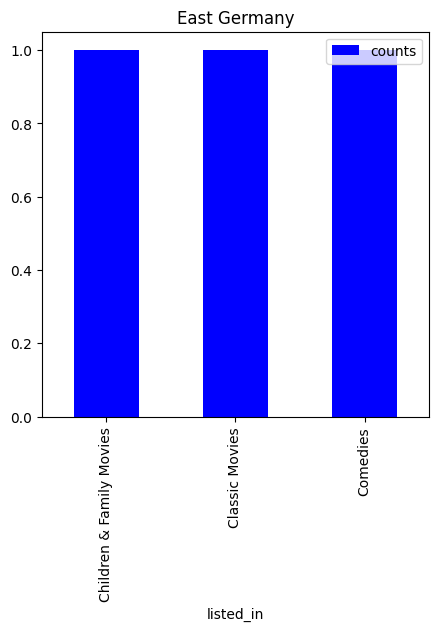

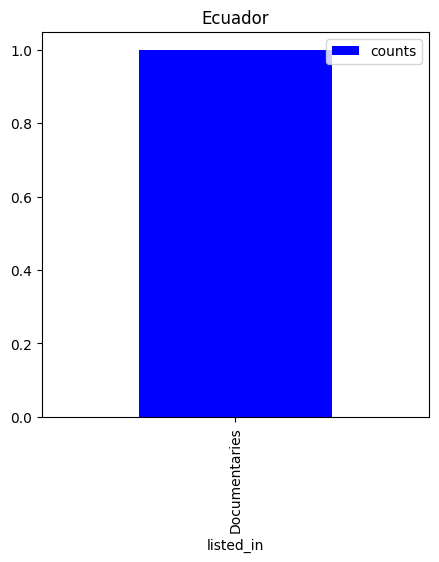

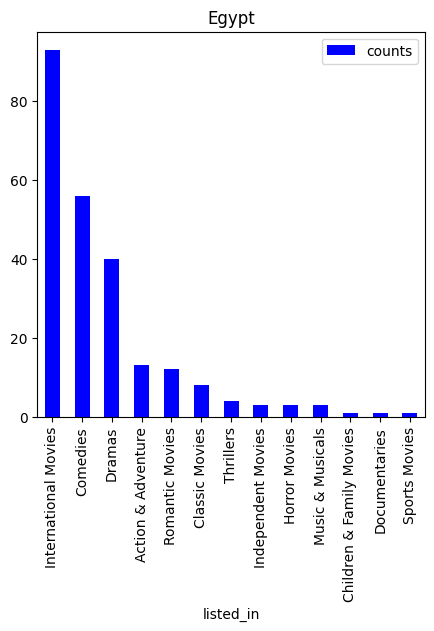

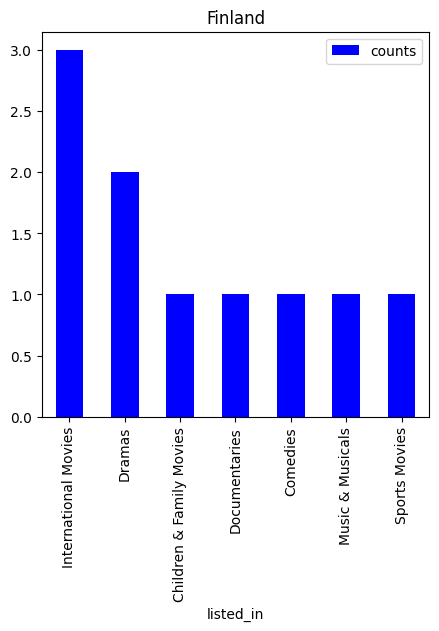

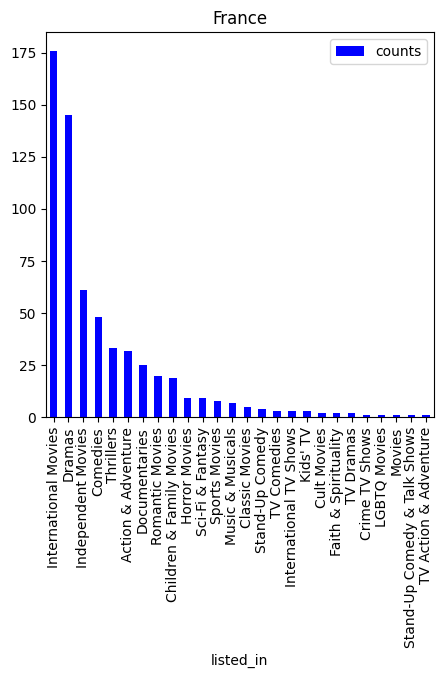

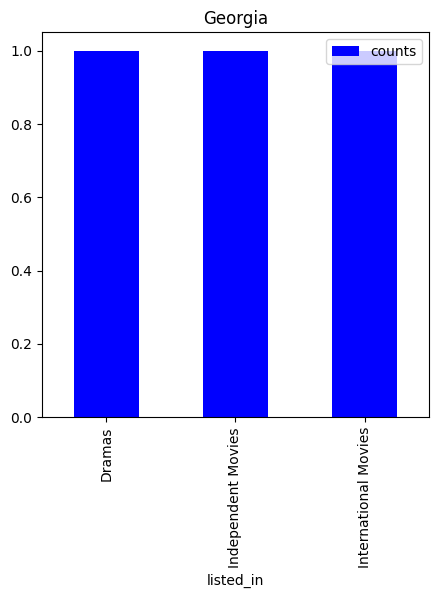

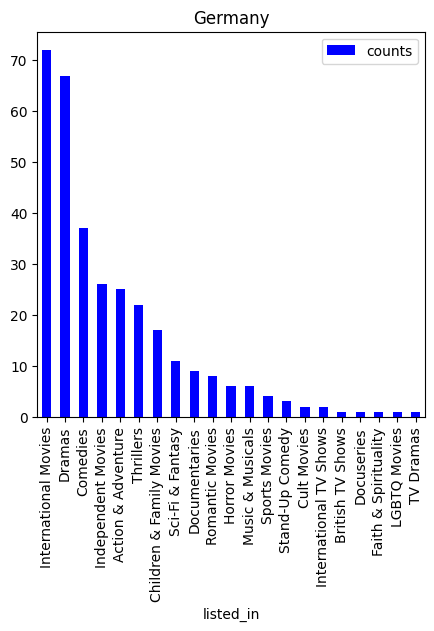

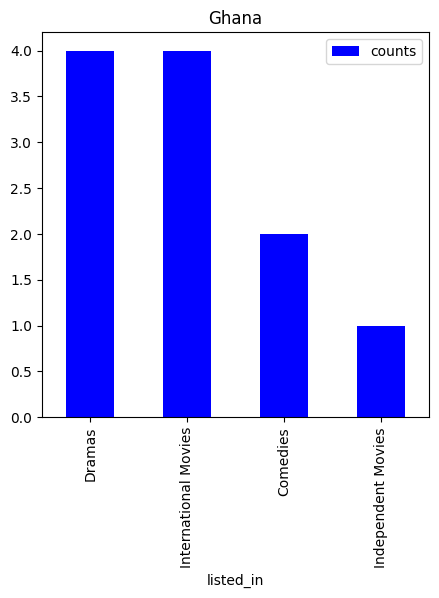

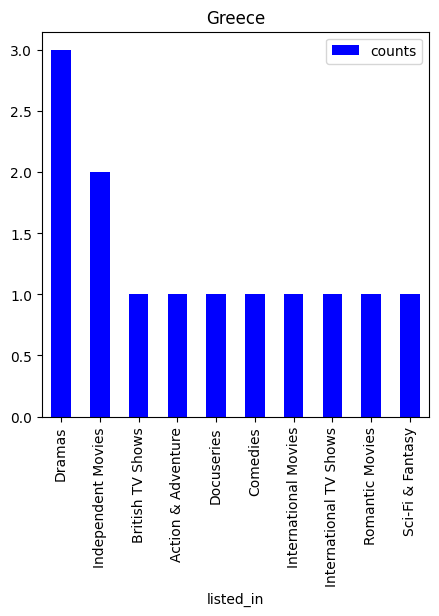

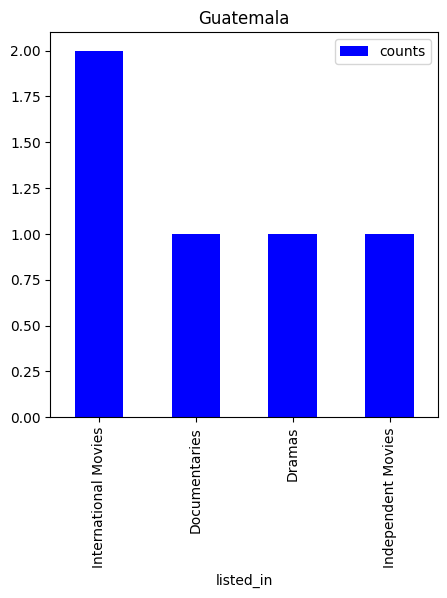

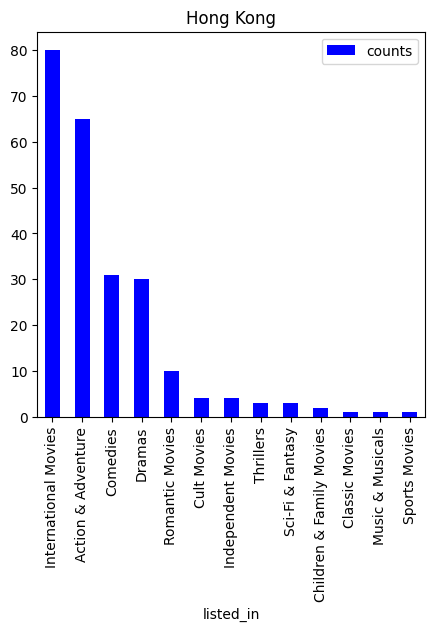

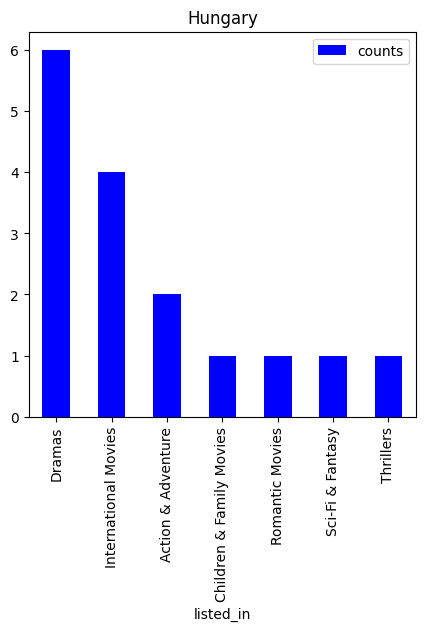

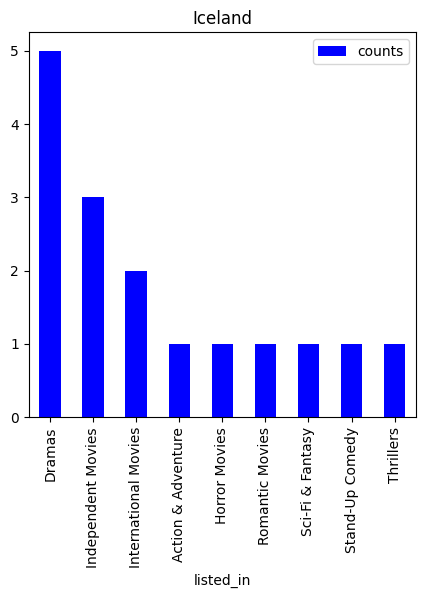

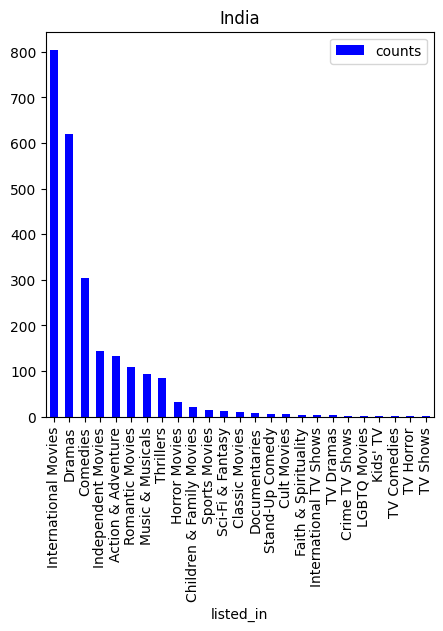

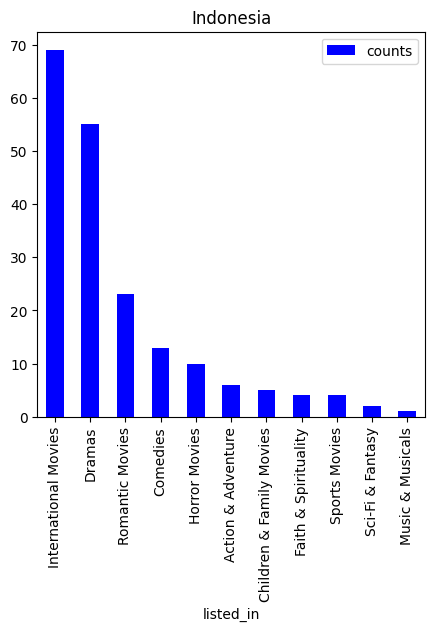

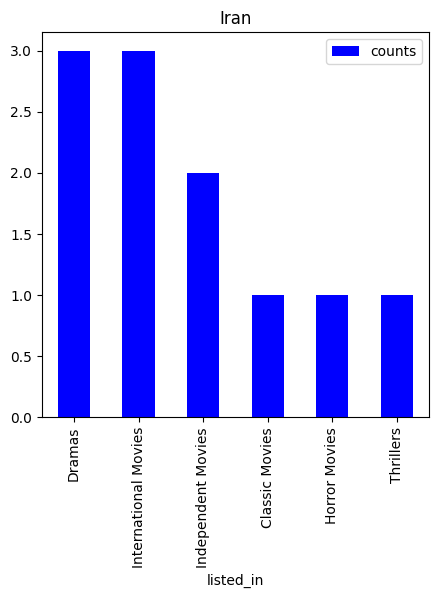

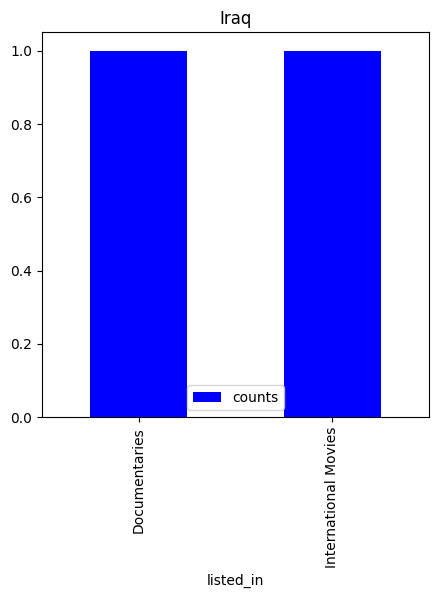

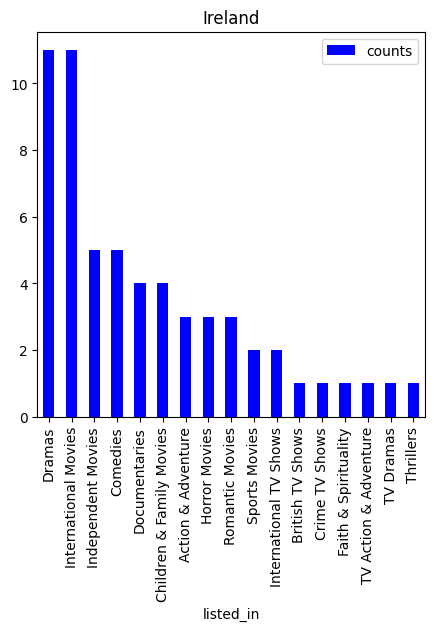

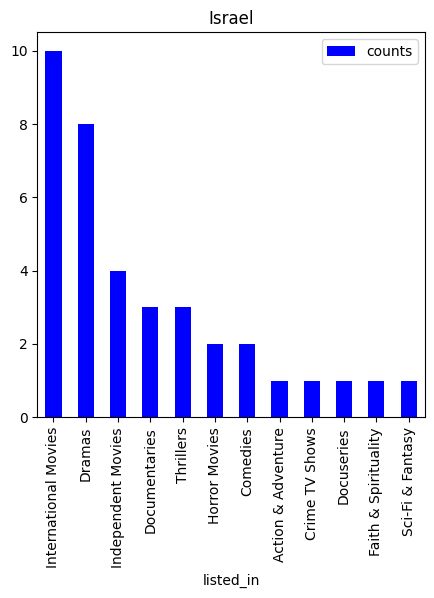

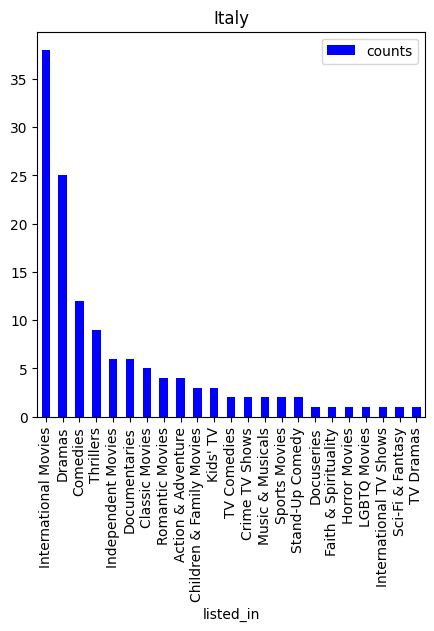

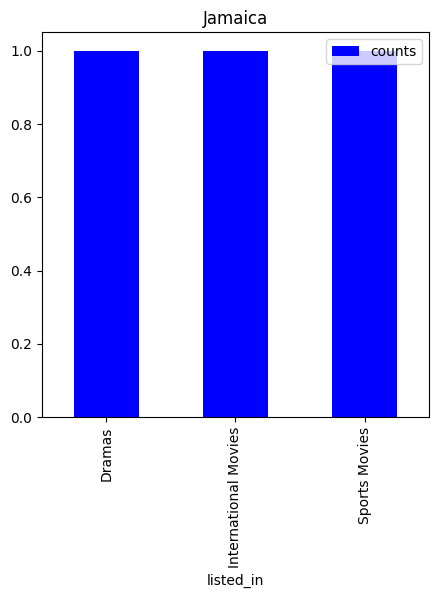

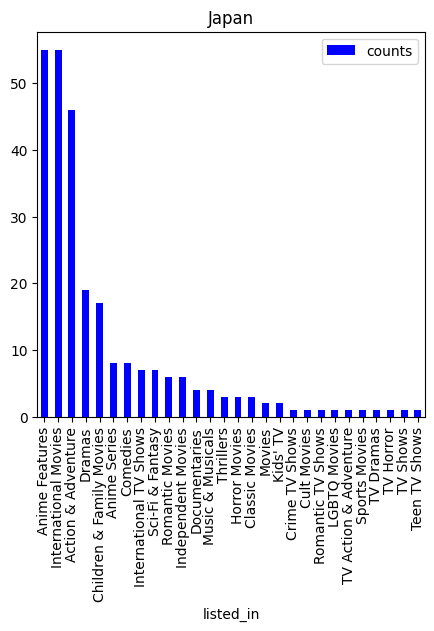

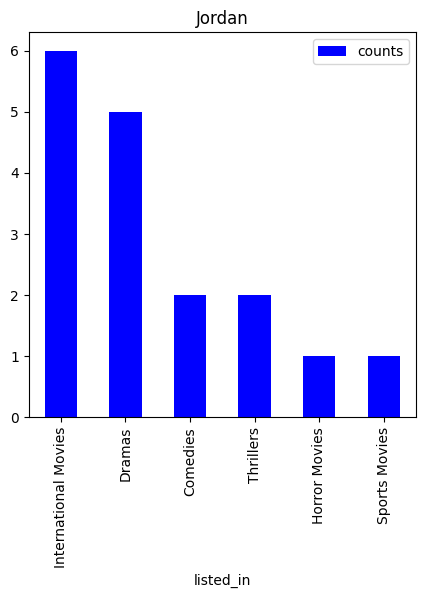

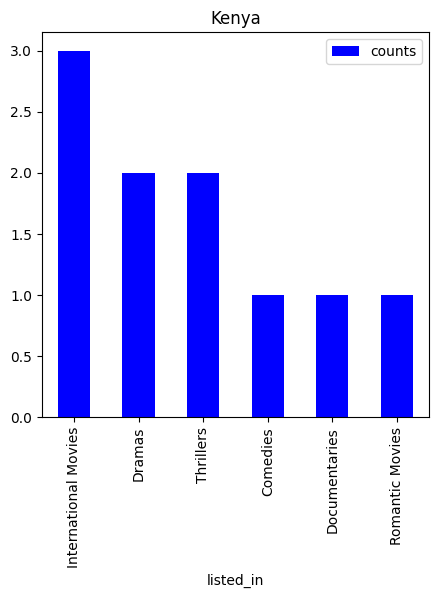

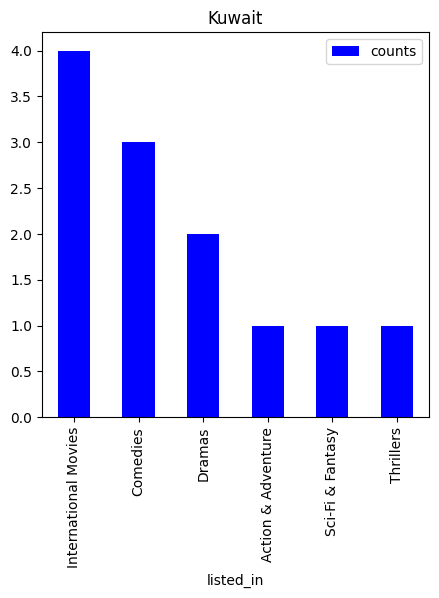

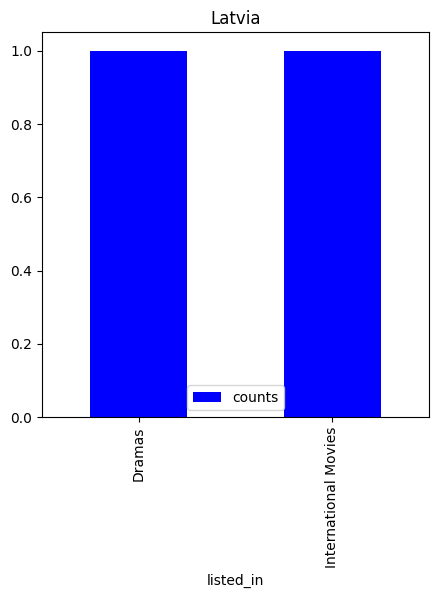

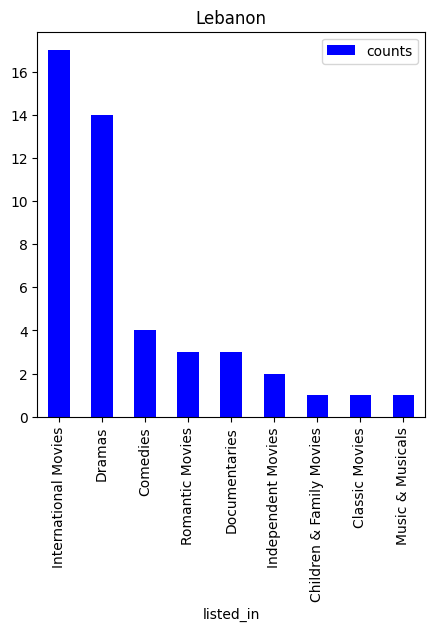

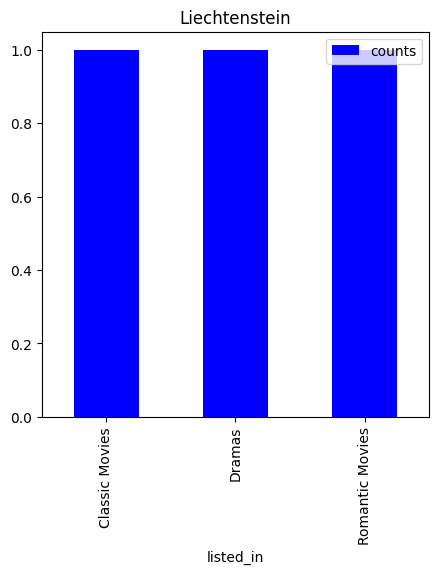

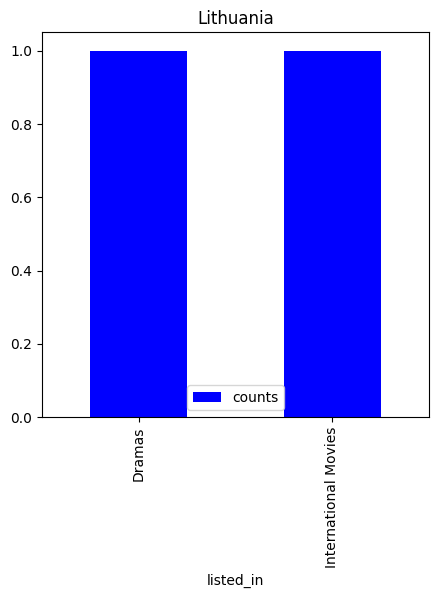

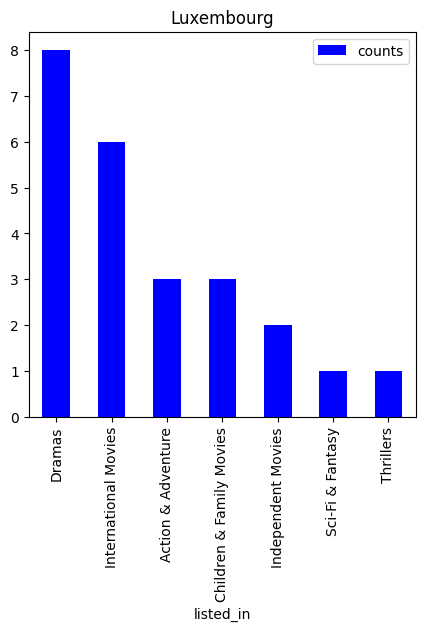

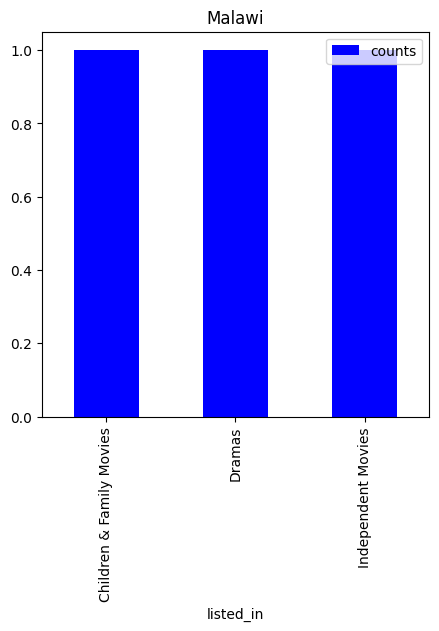

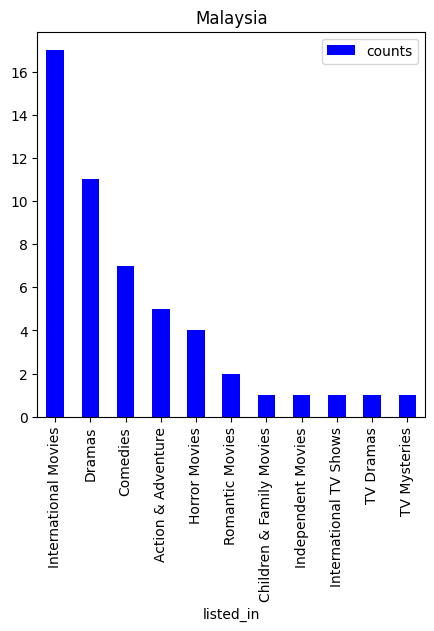

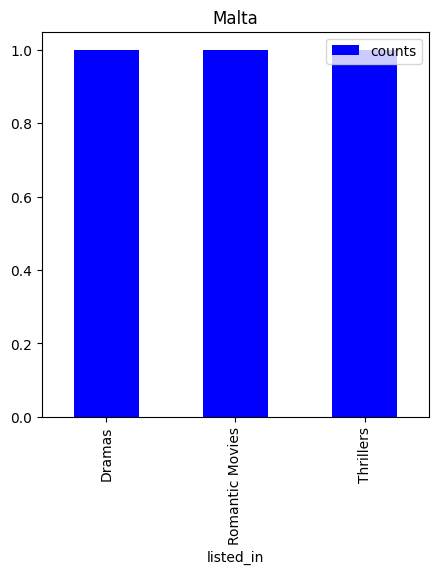

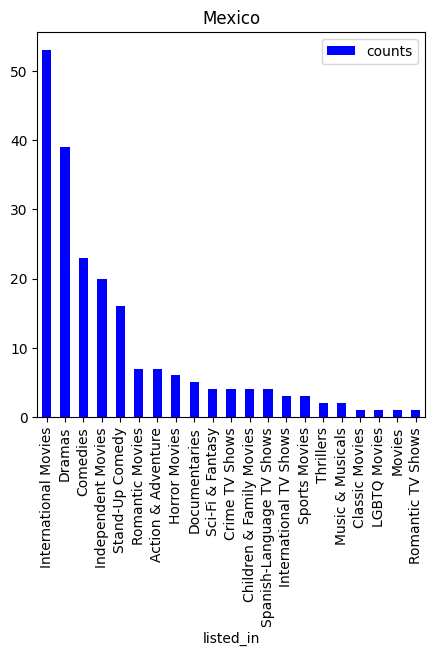

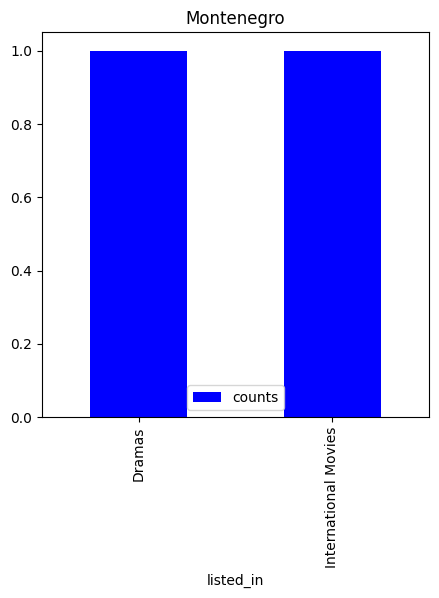

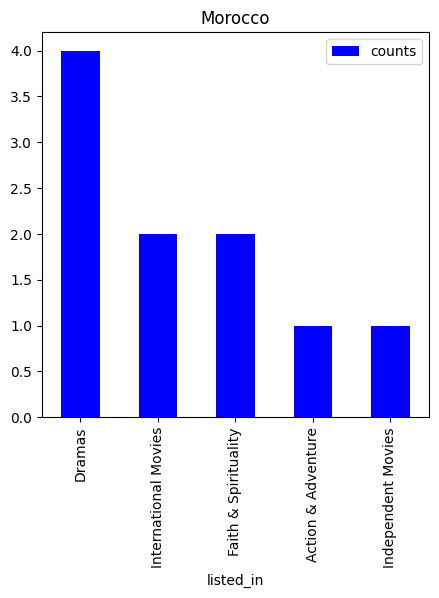

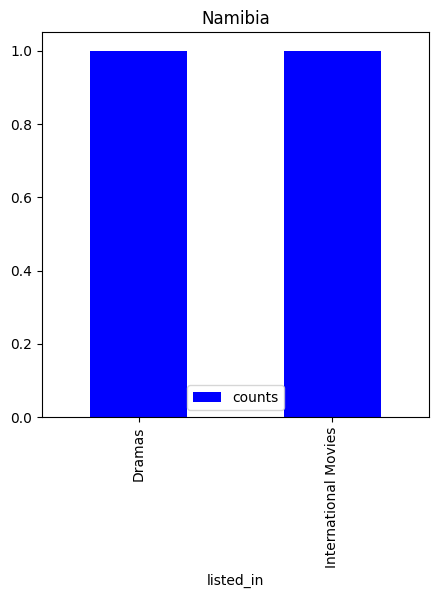

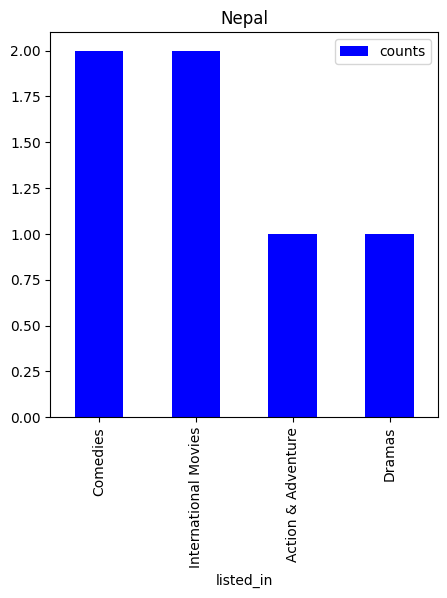

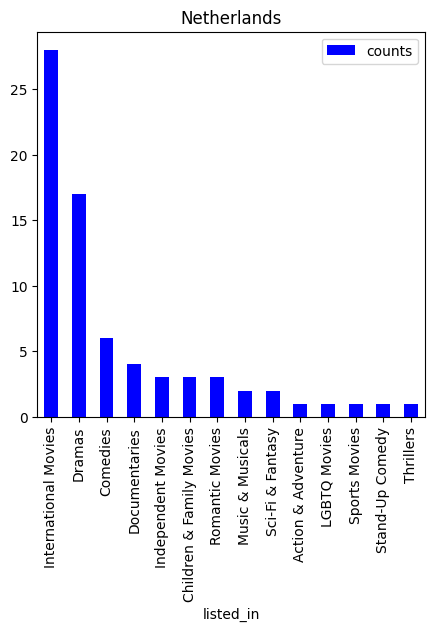

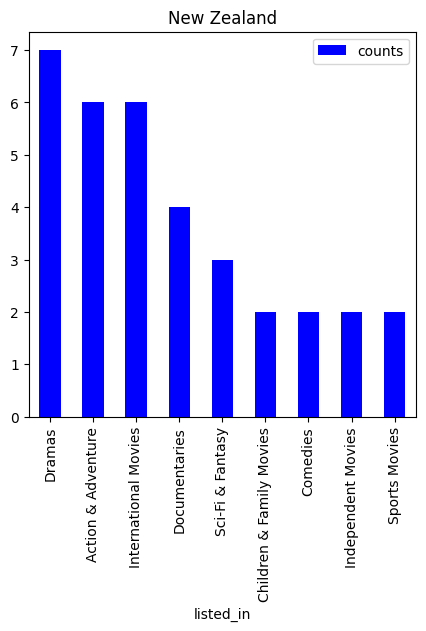

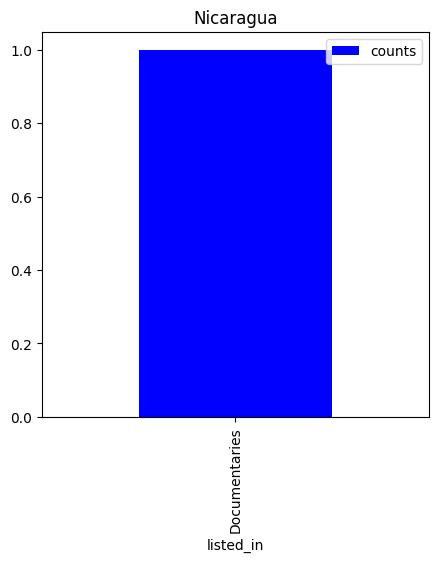

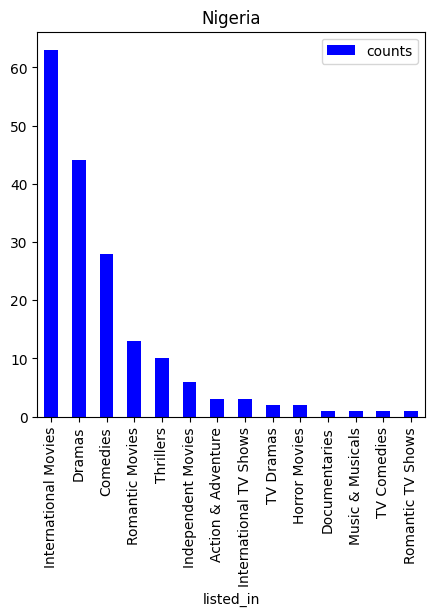

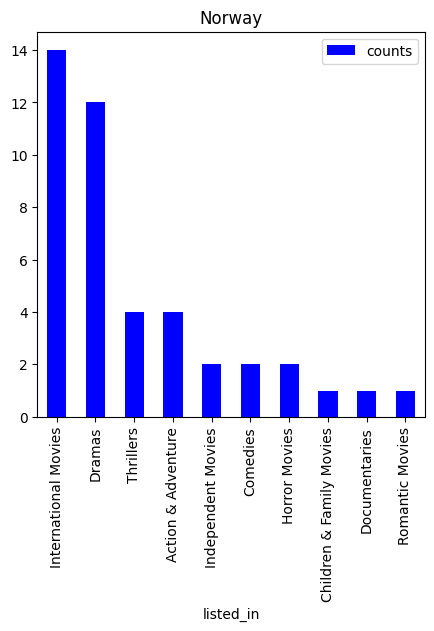

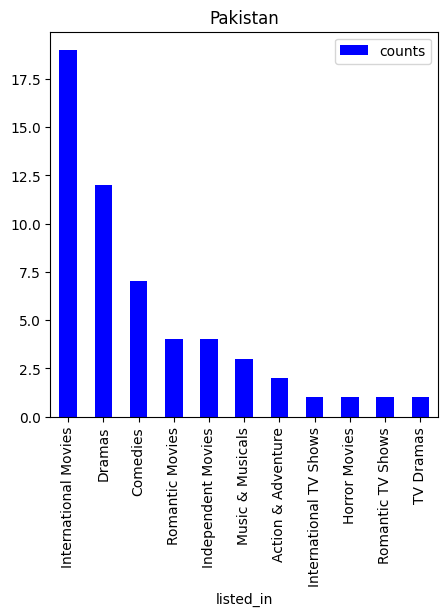

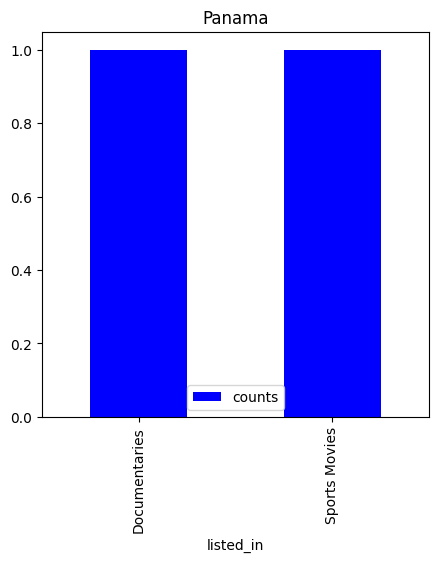

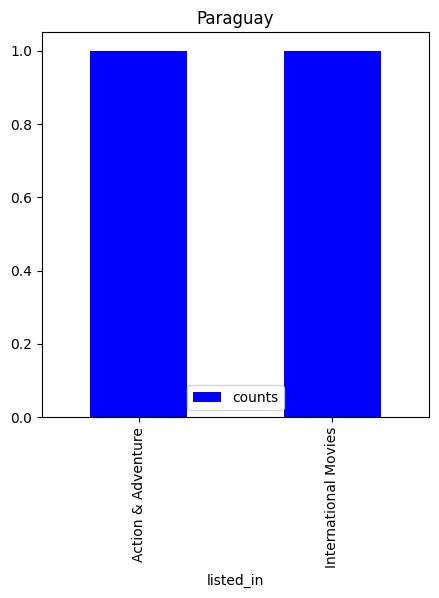

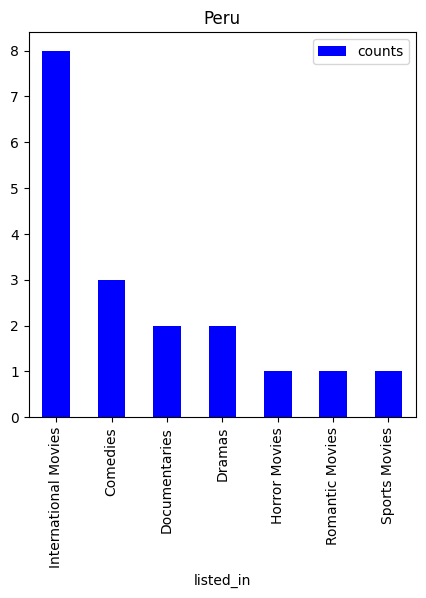

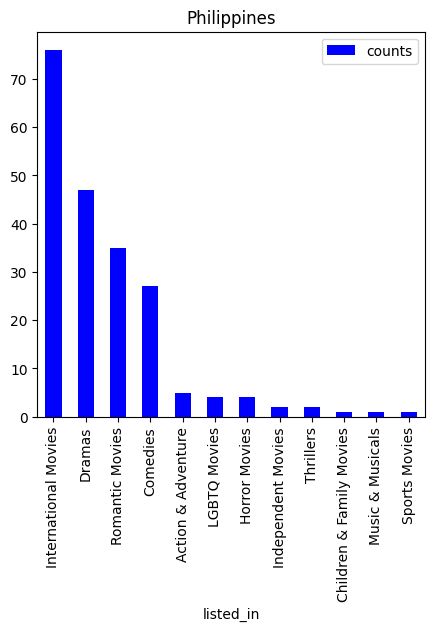

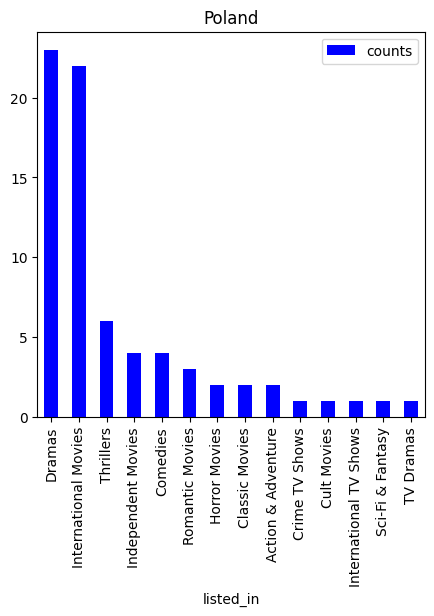

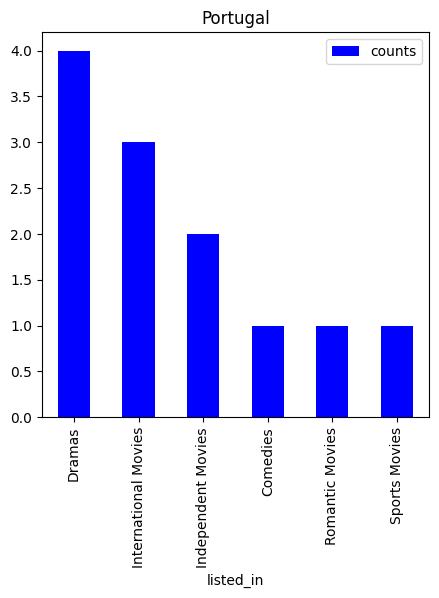

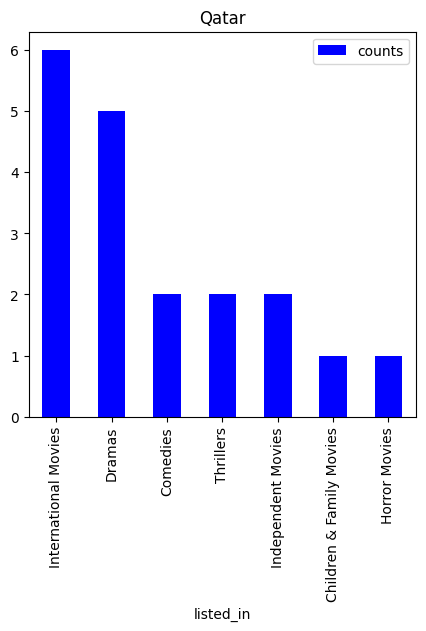

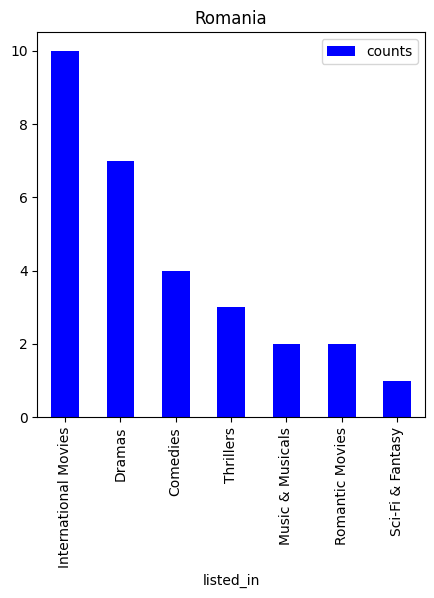

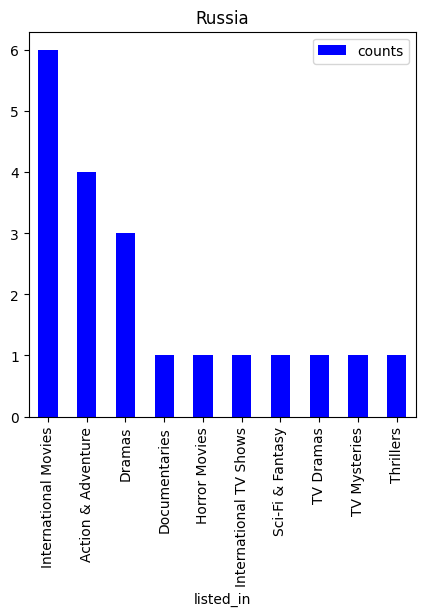

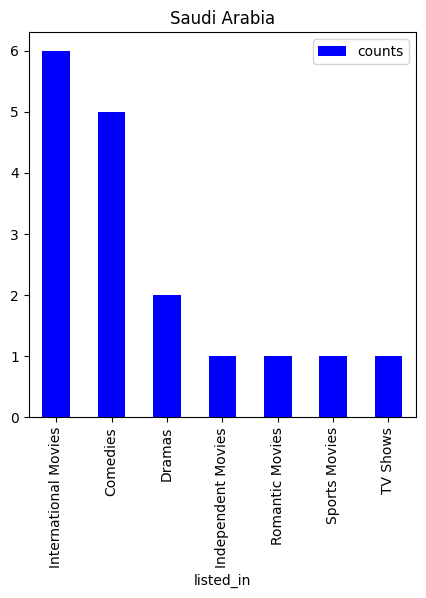

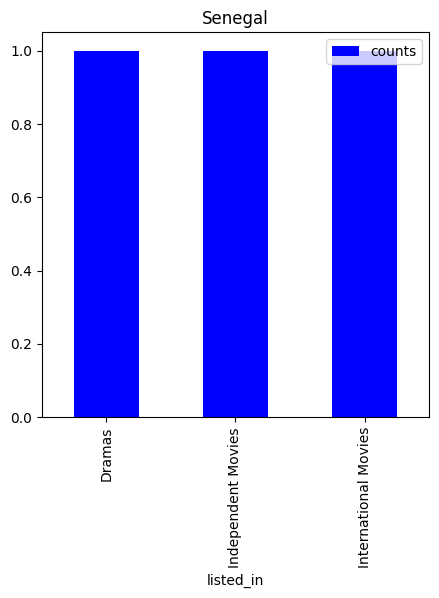

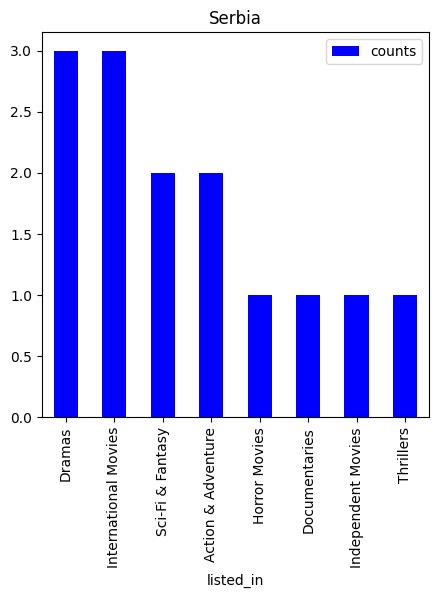

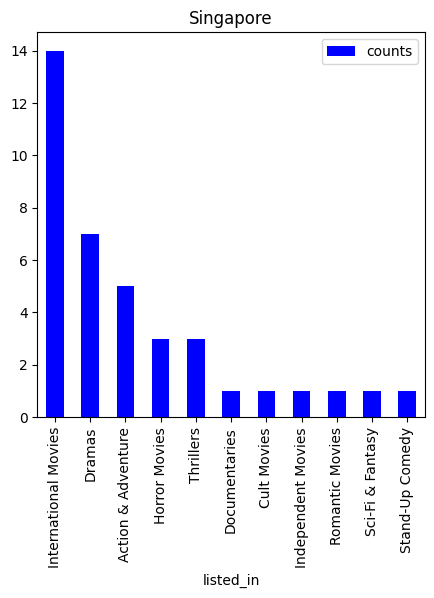

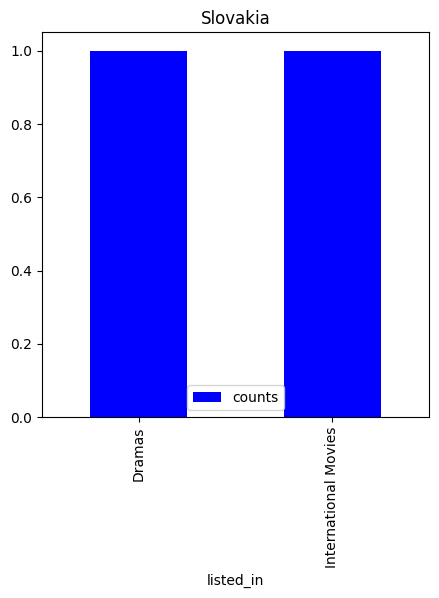

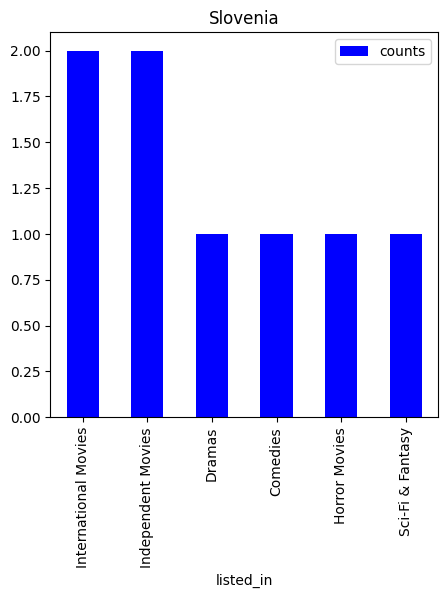

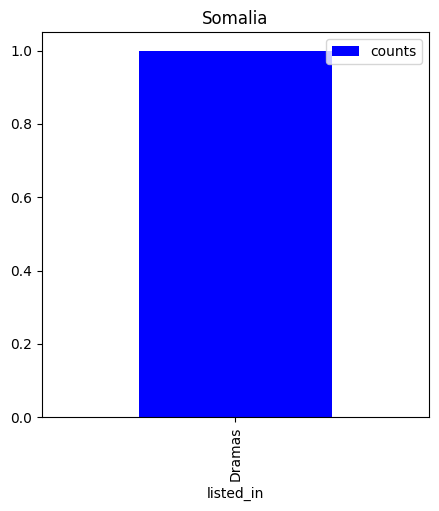

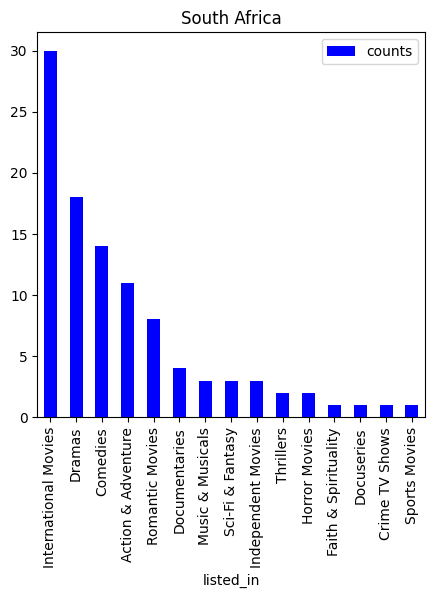

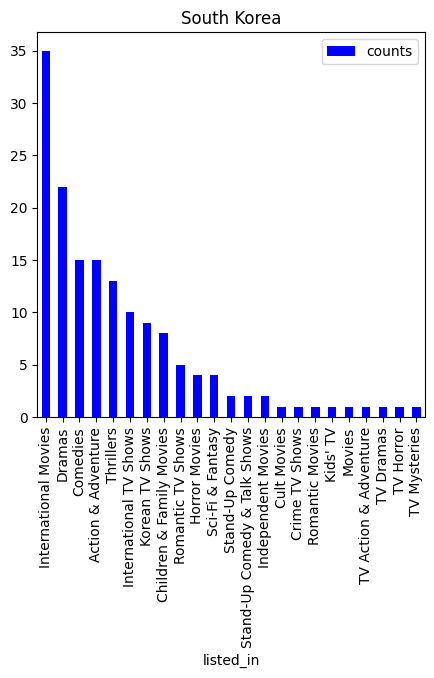

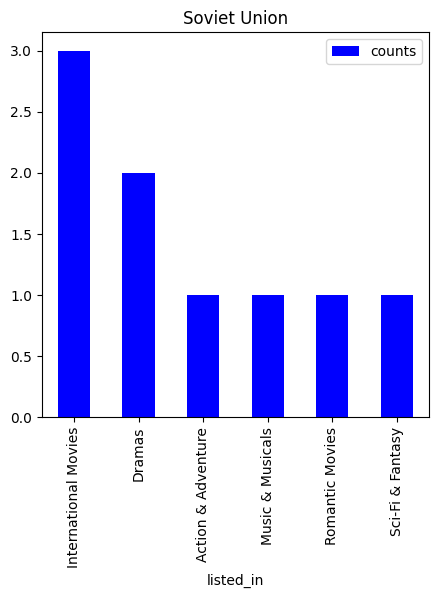

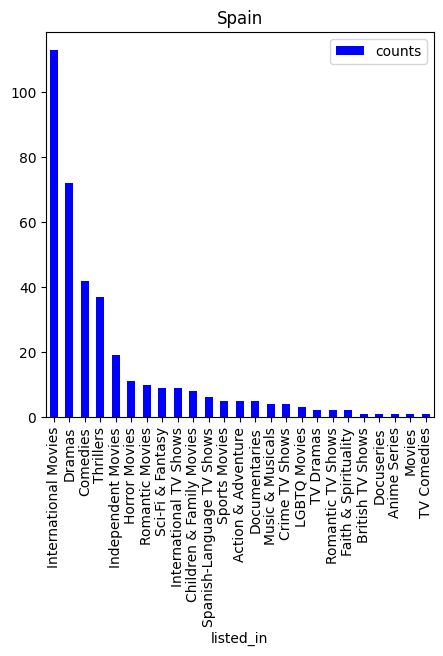

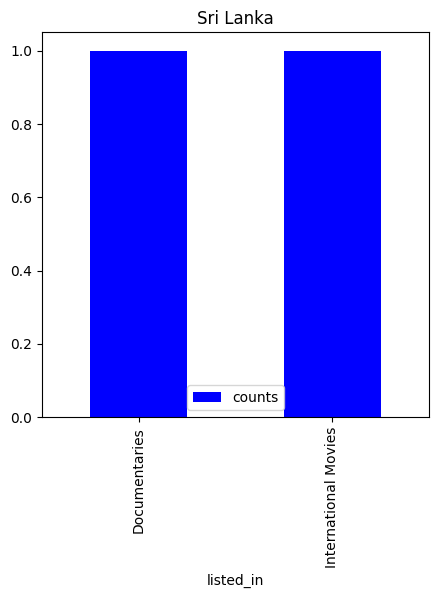

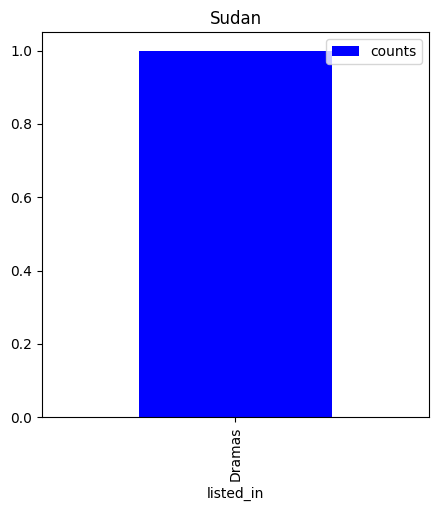

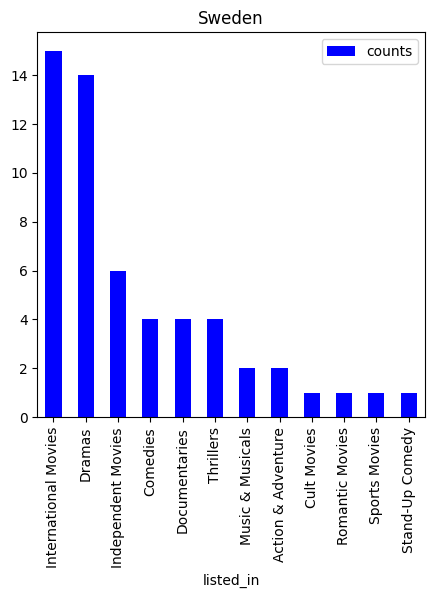

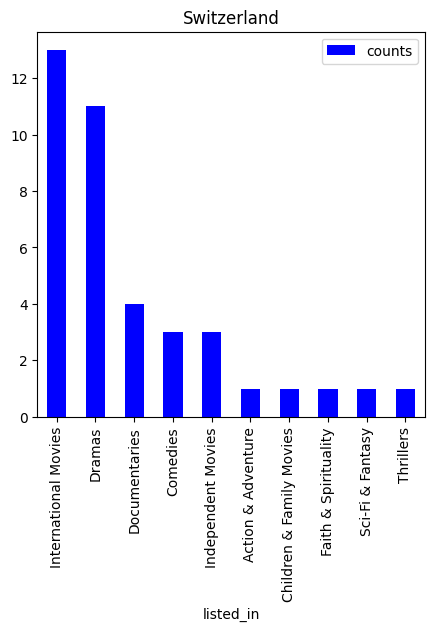

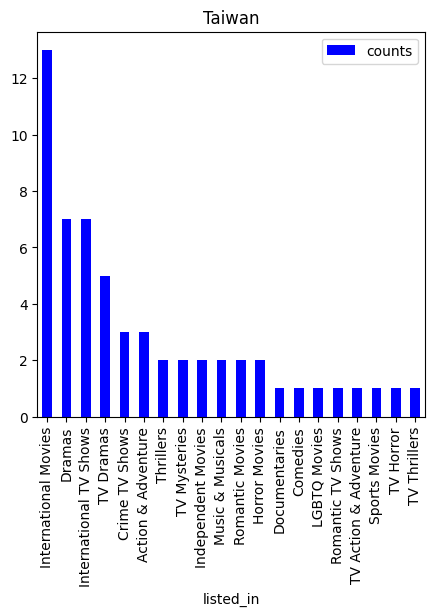

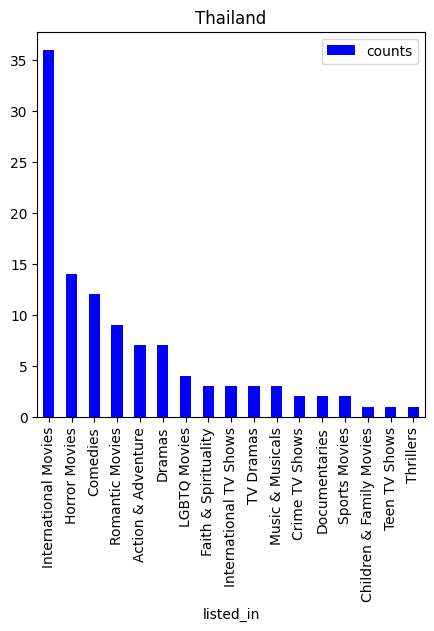

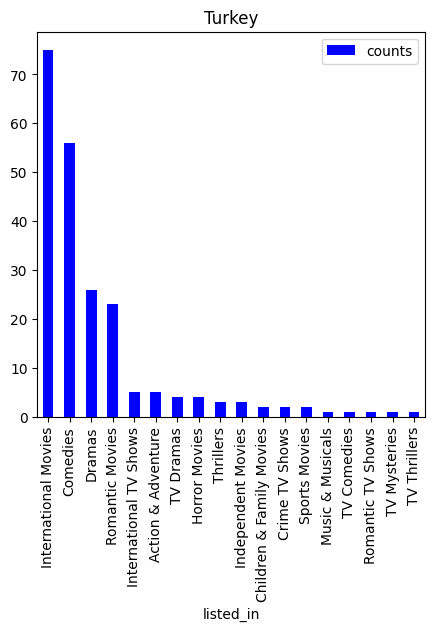

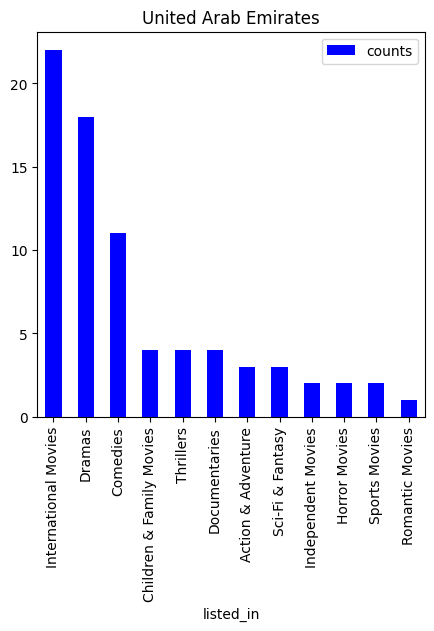

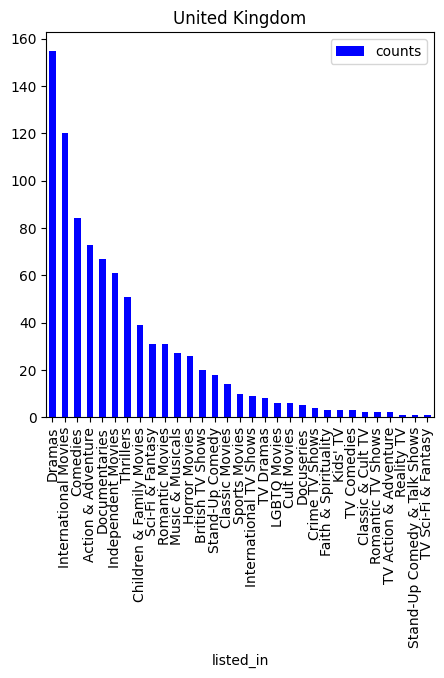

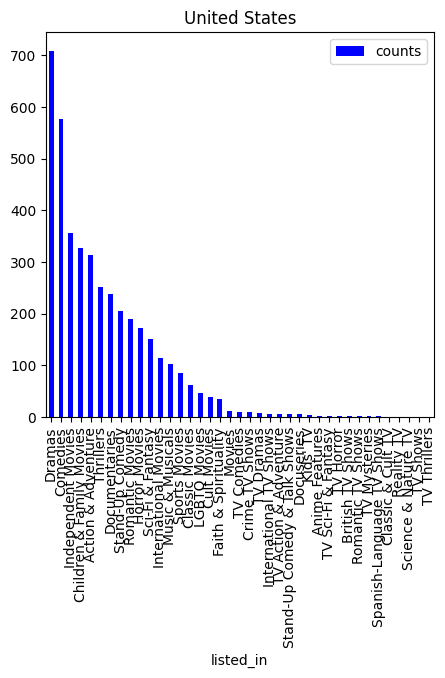

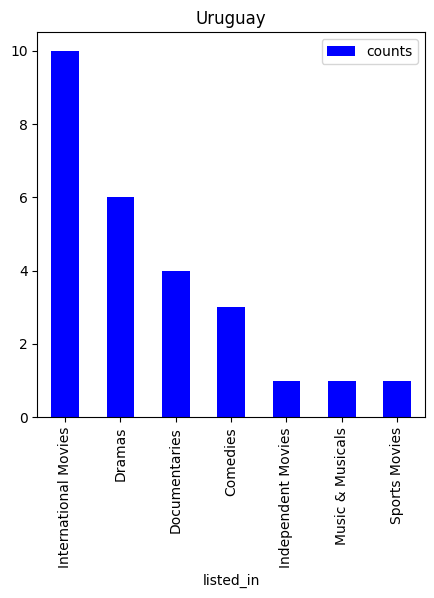

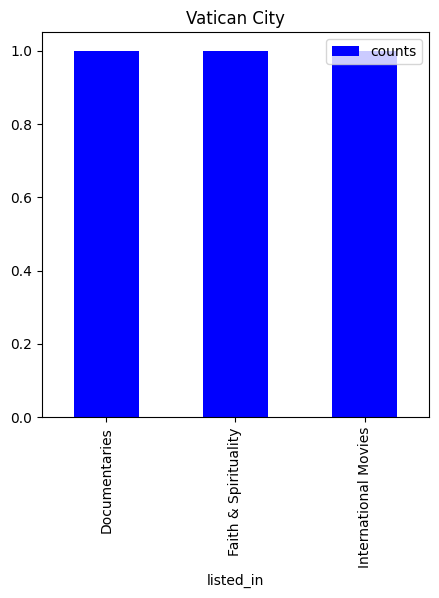

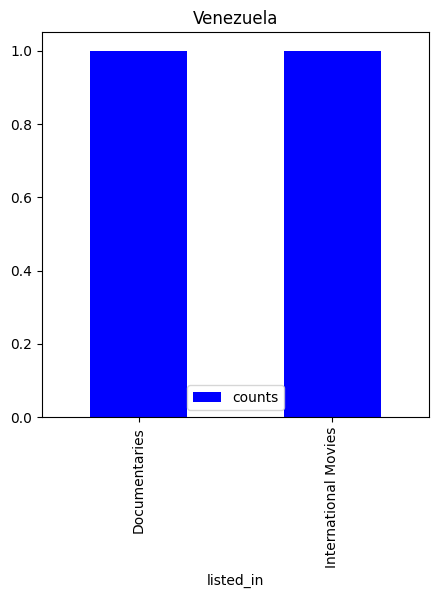

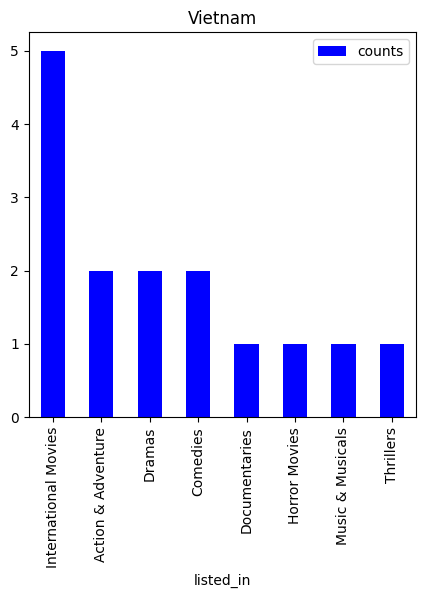

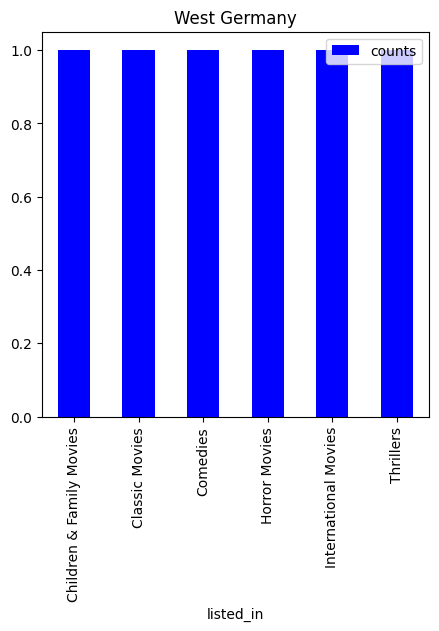

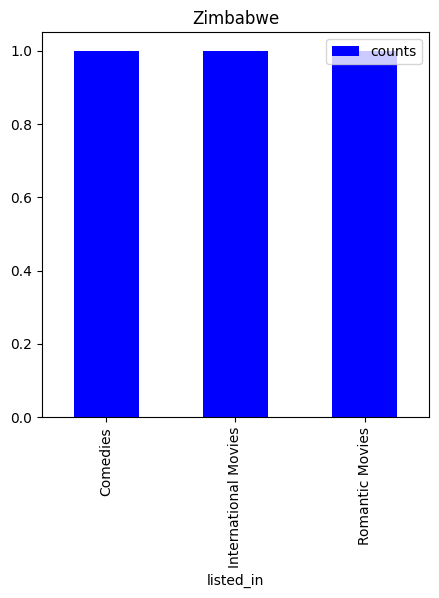

In [5]:
# split strings with multiple countries in the cells of column 'country' so that we can get idividual countries
q4 = df.set_index(['show_id', 'type', 'title', 'director', 'cast', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']) \
.apply(lambda x: x.str.split(', ').explode()).reset_index()

# same for column 'listed_in'
q4 = q4.set_index(['show_id', 'type', 'title', 'director', 'cast', 'date_added', 'release_year', 'rating', 'duration', 'country', 'description']) \
.apply(lambda x: x.str.split(', ').explode()).reset_index()

# replace errors in data (some strings in column 'country' is not completed -they have ',' without something afterwards)
q4.country = q4.country.str.replace(',', '')

# count the number of content for each unique genre and create plots for each country
q4 = q4.groupby(['country', 'listed_in']).size().reset_index(name='counts')
for country in q4.country.unique():
  grouped = q4.loc[q4['country'] == country]
  grouped = grouped.sort_values(['counts'], ascending=False, ignore_index=True)
  grouped.plot.bar(x='listed_in', y='counts', figsize=(5, 5), title=country, color='blue')

## **Ερώτημα 5**

Give a country: 
United States


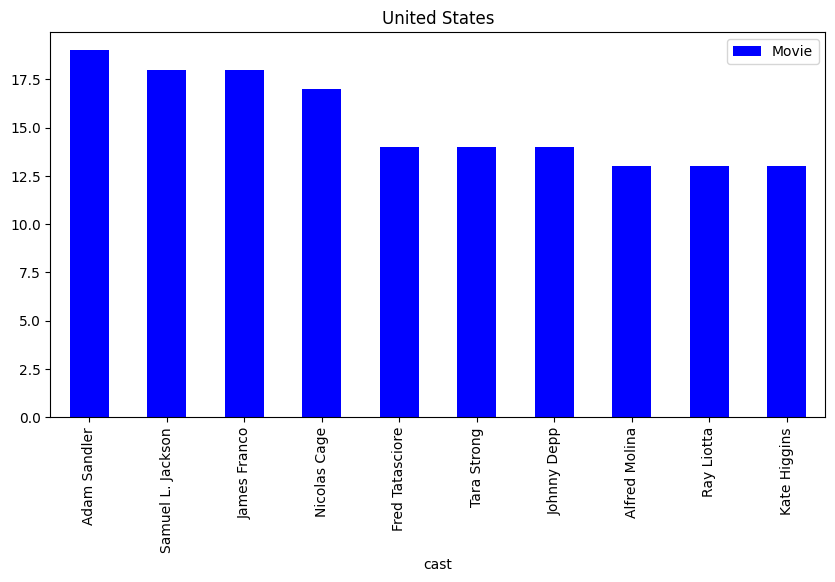

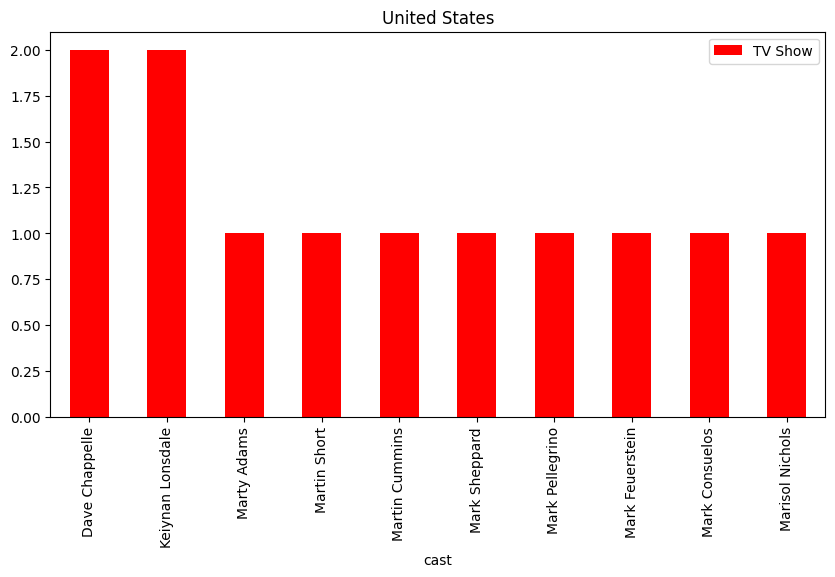

In [6]:
# split strings with multiple countries in the cells of column 'country' so that we can get idividual countries
q5 = df.set_index(['show_id', 'type', 'title', 'director', 'cast', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']) \
.apply(lambda x: x.str.split(', ').explode()).reset_index()

# same for actors
q5 = q5.set_index(['show_id', 'type', 'title', 'director', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']) \
.apply(lambda x: x.str.split(', ').explode()).reset_index()

# replace errors in data (some strings in column 'country' is not completed -they have ',' without something afterwards)
q5.country = q5.country.str.replace(',', '')

q5 = q5.groupby(['country', 'type', 'cast']).size().reset_index(name='counts')
c = ['blue', 'red'] # colors for the plot
i = 0

# give a country as input
# if none, by default United Stated actors is shown
print('Give a country: ')
country = input()
for types in q5.type.unique():
  if not country:
    country = 'United States'
  grouped = q5.loc[(q5['country'] == country) & (q5['type'] == types)]
  if grouped.empty:
    continue
  grouped = grouped.sort_values(['counts'], ascending=False, ignore_index=True)
  grouped[:10].plot.bar(x='cast', y='counts', figsize=(10, 5), title=country, color=c[i], label=types)
  i += 1

## **Ερώτημα 6**

type       rating  counts
0    Movie  Little Kids     181
1    Movie       Mature    2250
2    Movie   Older Kids     702
3    Movie        Teens    1473
4  TV Show  Little Kids       8
5  TV Show       Mature      71
6  TV Show   Older Kids      21
7  TV Show        Teens      35

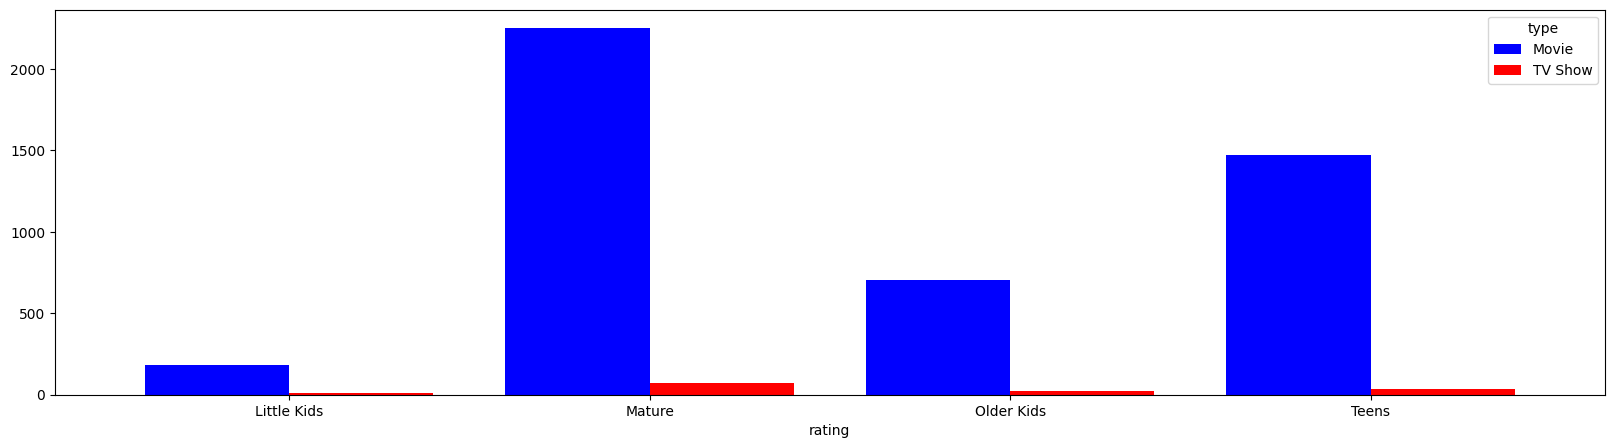

In [7]:
# create new dataframe that is group by rating and has a column for the number of ratings for each unique rate
q6 = df.groupby(['rating', 'type']).size().reset_index(name='counts')

# drop un-rated
q6 = q6.loc[q6['rating'].isin(['UR', 'NR']) == False]

# replace ratings that have similar meaning with one individual
q6 = q6.replace(['G', 'TV-Y', 'TV-G'], 'Little Kids').replace(['PG', 'TV-Y7', 'TV-Y7-FV', 'TV-PG'], 'Older Kids').replace(['PG-13', 'TV-14'], 'Teens').replace(['R', 'NC-17', 'TV-MA'], 'Mature')

# summarize the number of movies/tv shows by rating
aggregation_functions = {'counts': 'sum'}
q6 = q6.groupby(['type', 'rating']).aggregate(aggregation_functions).reset_index()

# create one plot for both movies & tv shows
q6.pivot(index='rating', columns='type', values='counts').plot.bar(figsize=(20, 5), width=0.8, color=['blue', 'red'])
plt.xticks(rotation=360)
q6

## **Ερώτημα 7**

date_added                                               type  counts
0     October  MovieMovieMovieMovieMovieMovieMovieMovieMovieM...     487
1     January  MovieMovieMovieMovieMovieMovieMovieMovieMovieM...     486
2    December  MovieMovieMovieMovieMovieMovieMovieMovieMovieM...     478
3    November  MovieMovieMovieMovieMovieMovieMovieMovieMovieM...     464
4       March  MovieMovieMovieMovieMovieMovieMovieMovieMovieM...     410
5       April  MovieMovieMovieMovieMovieMovieMovieMovieMovieM...     361
6        July  MovieMovieMovieMovieMovieMovieMovieMovieMovieM...     360
7      August  MovieMovieMovieMovieMovieMovieMovieMovieMovieM...     359
8   September  MovieMovieMovieMovieMovieMovieMovieMovieMovieM...     344
9        June  MovieMovieMovieMovieMovieMovieMovieMovieMovieM...     327
10        May  MovieMovieMovieMovieMovieMovieMovieMovieMovieM...     315
11   February  MovieMovieMovieMovieMovieMovieMovieMovieMovieM...     282

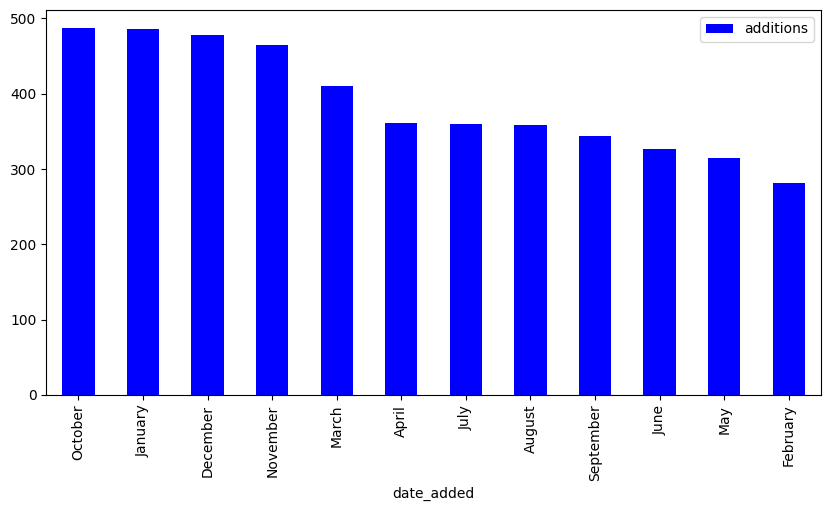

In [8]:
# create new dataframe that is group by date_added and has a column for the number of movies/tv shows of each date
q7 = df.groupby(['date_added', 'type']).size().reset_index(name='counts')

# keep only movies data
q7 = q7.loc[q7['type'] == 'Movie']

# split the date and take only the year out of it
q7['date_added'] = q7['date_added'].str.split(' ').str[0]

# summarize the number of movies/tv shows by year
q7 = q7.groupby('date_added').sum().reset_index()

q7 = q7.sort_values(['counts'], ascending=False, ignore_index=True)
q7.plot.bar(x='date_added', y='counts', figsize=(10, 5), color='blue', label='additions')
q7

## **Ερώτημα 8**

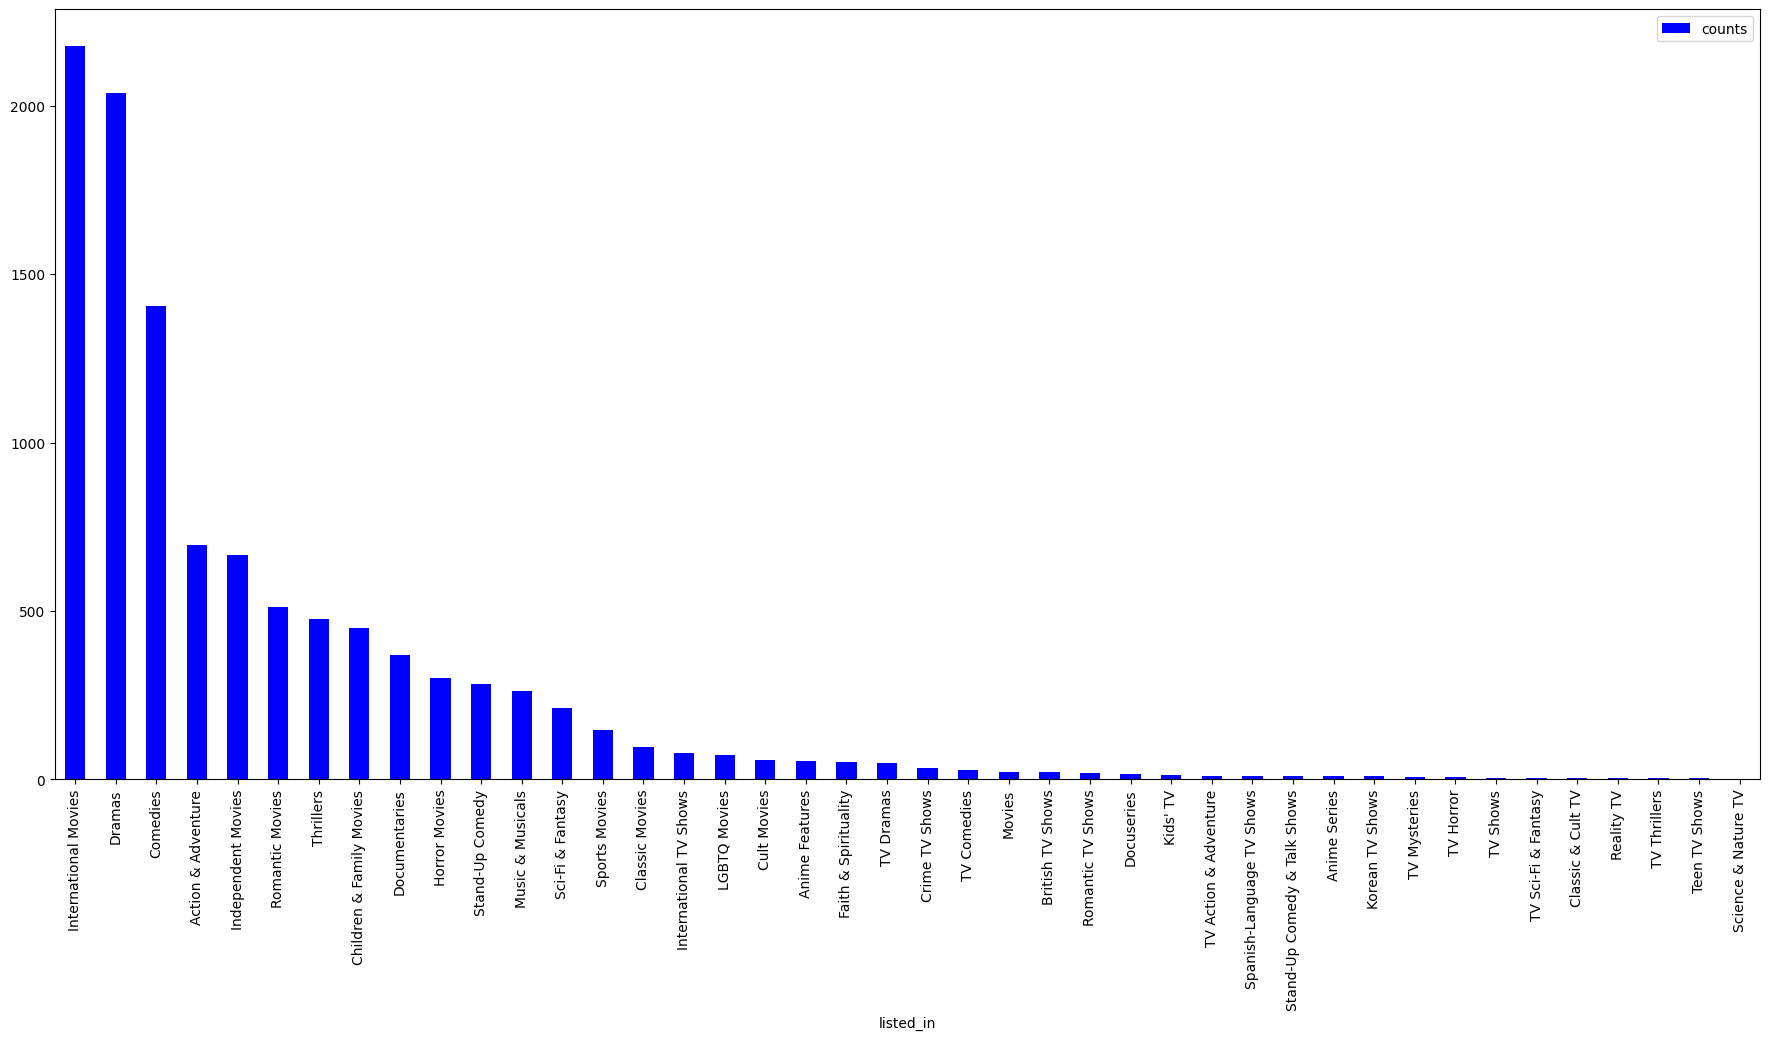

In [9]:
# split strings with multiple genres in the cells of column 'listed_in' so that we can get idividual genres
q8 = df.set_index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'description']) \
.apply(lambda x: x.str.split(', ').explode()).reset_index() \
.groupby('listed_in').size().reset_index(name='counts')

q8 = q8.sort_values(['counts'], ascending=False, ignore_index=True)
q8.plot.bar(x='listed_in', y='counts', figsize=(22, 10), color='blue');

## **Ερώτημα 9**

Give a country: 
United States


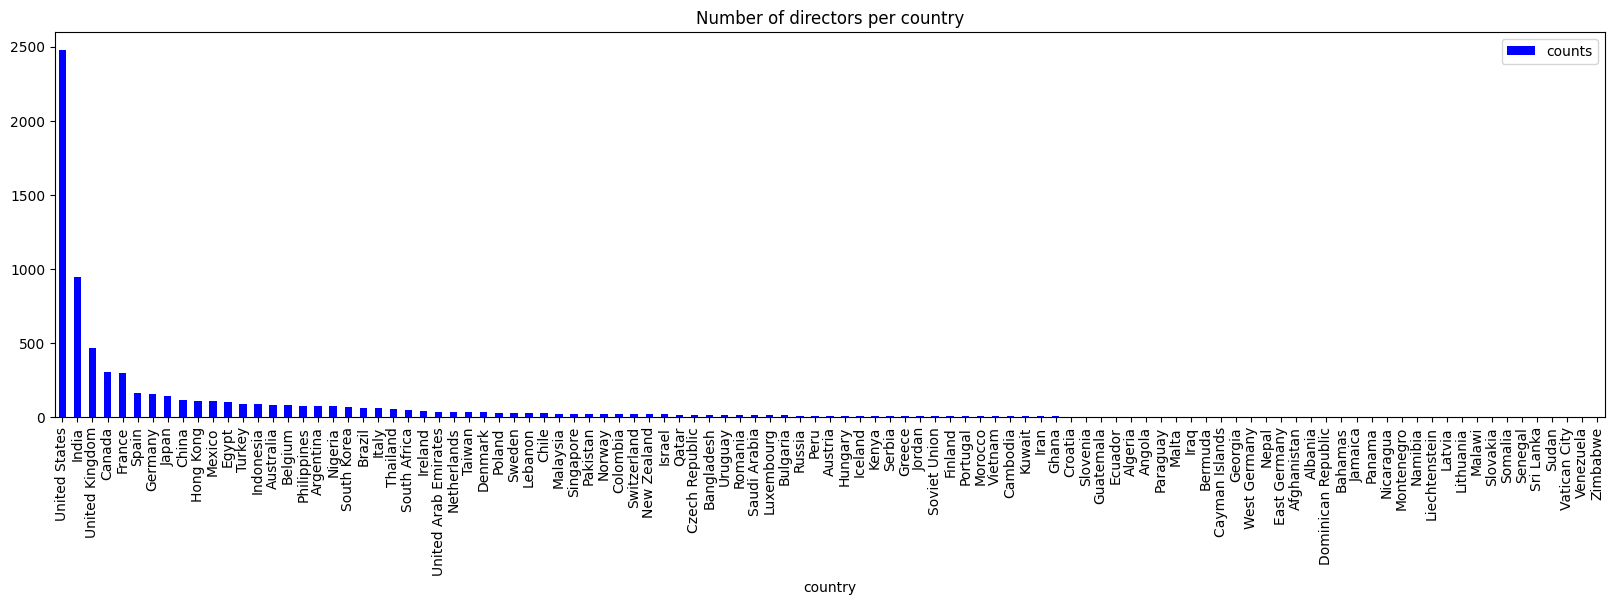

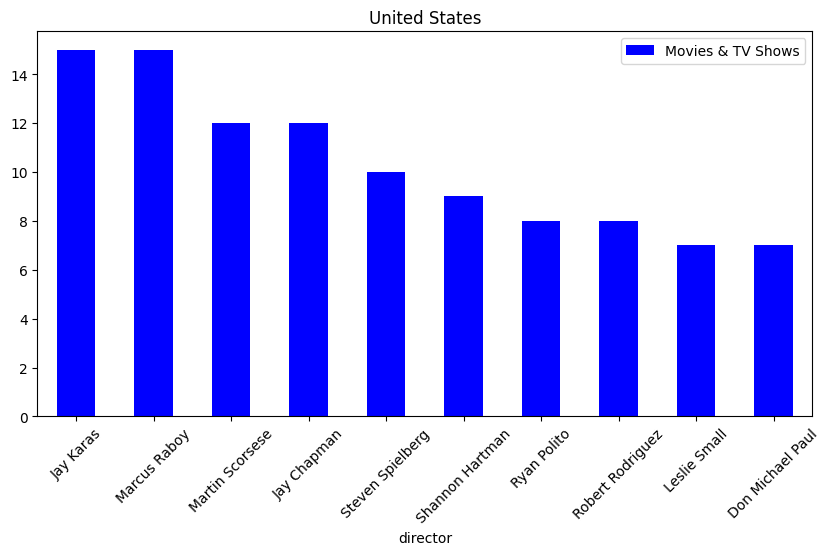

In [10]:
# split strings with multiple director in the cells of column 'director' so that we can get idividual directors
q9 = df.set_index(['show_id', 'type', 'title', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']) \
.apply(lambda x: x.str.split(', ').explode()).reset_index()

# same for countries
q9 = q9.set_index(['show_id', 'type', 'title', 'director', 'cast', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']) \
.apply(lambda x: x.str.split(', ').explode()).reset_index()

# replace errors in data (some strings in column 'country' is not completed -they have ',' without something afterwards)
q9.country = q9.country.str.replace(',', '')

q9 = q9.groupby(['country', 'director']).size().reset_index(name='counts')
grouped = q9.groupby('country').sum().reset_index()
grouped = grouped.sort_values('counts', ascending=False, ignore_index=True)

# 1st plot: number of directors for each country
grouped.plot.bar(x='country', y='counts', figsize=(20, 5), color='blue', title='Number of directors per country')

# rest plots: most popular directors for country given as input, based on the number of movies/tv shows they've directed
# if none, by default United Stated most popular direcotrs are shown
print('Give a country: ')
country = input()
if not country:
  country = 'United States'
grouped = q9.loc[q9['country'] == country].sort_values('counts', ascending=False, ignore_index=True)
grouped[:10].plot.bar(x='director', y='counts', figsize=(10, 5), title=country, label='Movies & TV Shows', color='blue')
plt.xticks(rotation=45);

## **Ερώτημα 10**

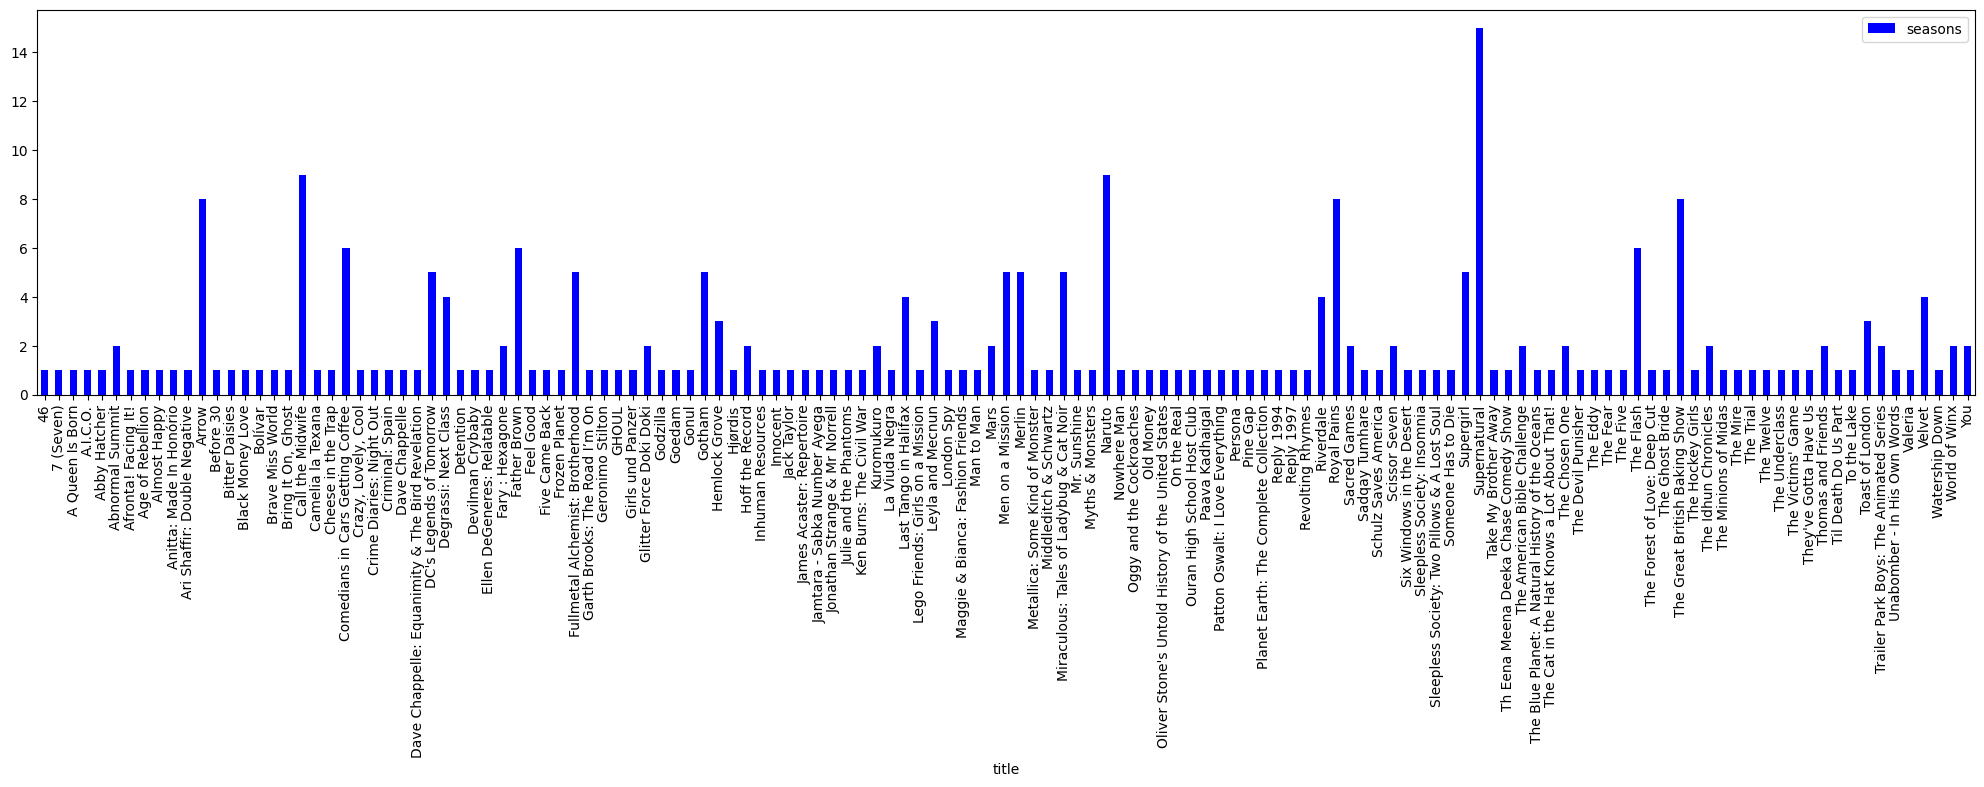

In [12]:
# create new dataframe that contains only data with type 'TV Show'
q10 = df.loc[df['type'] == 'TV Show']

# replace 'Season(s)' string with empty string and convert the number of seasons to int
q10['duration'] = q10.duration.str.replace(r'[ ]?Season[s]?', '', regex=True)
q10['duration'] = q10['duration'].astype(int)

q10.plot.bar(x='title', y='duration', figsize=(25, 5), label='seasons', color='blue');

## **Ερώτημα 11**

title  avg_vote
0                       Innocent       9.0
1               Schindler's List       8.9
2                   Pulp Fiction       8.9
3                      Inception       8.8
4         Much Ado About Nothing       8.6
5                       Gol Maal       8.6
6         Eh Janam Tumhare Lekhe       8.6
7          Oththa Seruppu Size 7       8.6
8  Ani... Dr. Kashinath Ghanekar       8.6
9                        Koshish       8.6

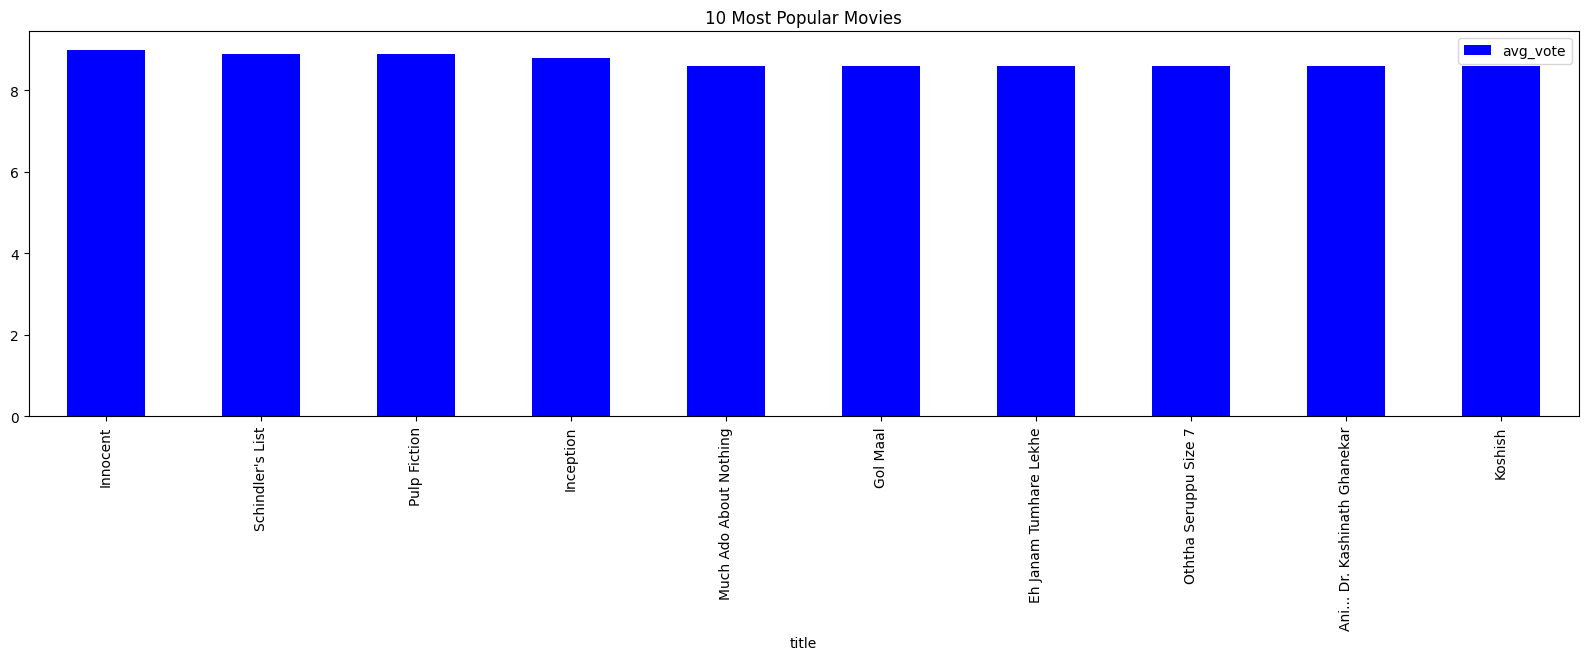

In [13]:
# create new dataframe that contains movies that are in both files 'netflix_files' & 'IMDb movies'
q11 = df_2.loc[df_2.title.isin(df.title)]

# sort movies by column 'avg_vote'
q11 = q11.sort_values('avg_vote', ascending=False, ignore_index=True)

q11 = q11[['title', 'avg_vote']]
q11[:10].plot.bar(x='title', y='avg_vote', figsize=(20, 5), color='blue', title='10 Most Popular Movies')
q11[:10]

# **Recommendation system**




In [14]:
# create a new dataframe that contains all the movies
df_movies = df.loc[df['type'] == 'Movie']
# keep only the three required columns
df_movies = df_movies[['show_id', 'title', 'description']]

## **1.a**

In [17]:
# UNIGRAMS
# define a Count Vectorizer Object and remove all english stop words
cv_uni = CountVectorizer(ngram_range=(1,1), max_features=len(df_movies), stop_words='english')
# construct the required boolean BoW matrix by fitting and transforming the data
bow_uni = cv_uni.fit_transform(df_movies['description'] + df_movies['title']).toarray()
# create dataframe for the features vector
df_bow_uni = pd.DataFrame(bow_uni, index=df_movies.title, columns=cv_uni.get_feature_names_out())

# BIGRAMS
cv_bi = CountVectorizer(ngram_range=(2,2), max_features=len(df_movies), stop_words='english')
bow_bi = cv_bi.fit_transform(df_movies['description'] + df_movies['title']).toarray()
df_bow_bi = pd.DataFrame(bow_bi, index=df_movies.title, columns=cv_bi.get_feature_names_out())

## **1.b**

In [19]:
# UNIGRAMS
# define a Tfidf Vectorizer Object and remove all english stop words
v_uni = TfidfVectorizer(ngram_range=(1,1), max_features=len(df_movies), stop_words='english')
# construct the required tf-idf matrix by fitting and transforming the data
tfidf_uni = v_uni.fit_transform(df_movies['description'] + df_movies['title']).toarray()
# create dataframe for the features vector
df_tfidf_uni = pd.DataFrame(tfidf_uni, index=df_movies.title, columns=v_uni.get_feature_names_out())
# replace NaN values with zeros
df_tfidf_uni = df_tfidf_uni.fillna(0)

# BIGRAMS
v_bi = TfidfVectorizer(ngram_range=(2,2), max_features=len(df_movies), stop_words='english')
tfidf_bi = v_bi.fit_transform(df_movies['description'] + df_movies['title']).toarray()
df_tfidf_bi = pd.DataFrame(tfidf_bi, index=df_movies.title, columns=v_bi.get_feature_names_out())
df_tfidf_bi = df_tfidf_bi.fillna(0)

## **2.a**

In [20]:
# Jaccard/Tanimoto coefficient

# UNIGRAMS
jac_uni = 1-pairwise_distances(bow_uni, bow_uni, metric='jaccard')
df_jac_uni = pd.DataFrame(jac_uni, index=df_bow_uni.index, columns=df_bow_uni.index)
# prepare a dictionary
movies_recs_uni = {}
# iterate over the columns in the dataframe
for movie in df_jac_uni.columns:
  # extract the similarities of the column ranked by biggest
  similarity = df_jac_uni[movie].nlargest(100)
  # for each movie, create a key in the dictionary and assign a list that contains a ranking of its most similar movies
  data = {movie : [i for i in similarity.index if i!=movie]}
  movies_recs_uni.update(data)

# BIGRAMS
jac_bi = 1-pairwise_distances(bow_bi, bow_bi, metric='jaccard')
df_jac_bi = pd.DataFrame(jac_bi, index=df_bow_bi.index, columns=df_bow_bi.index)
movies_recs_bi = {}
for movie in df_jac_bi.columns:
  similarity = df_jac_bi[movie].nlargest(100)
  data = {movie : [i for i in similarity.index if i!=movie]}
  movies_recs_bi.update(data)

## **2.b**

In [21]:
# Cosine similarity

# UNIGRAMS
cos_uni = 1-pairwise_distances(tfidf_uni, tfidf_uni, metric='cosine')
df_cos_uni = pd.DataFrame(cos_uni, index=df_tfidf_uni.index, columns=df_tfidf_uni.index)
# prepare a dictionary
movies_recs_uni_2 = {}
# iterate over the columns in the dataframe
for movie in df_cos_uni.columns:
  # extract the similarities of the column ranked by biggest
  similarity = df_cos_uni[movie].nlargest(100)
  # for each movie, create a key in the dictionary and assign a list that contains a ranking of its most similar movies
  data = {movie : [i for i in similarity.index if i!=movie]}
  movies_recs_uni_2.update(data)

# BIGRAMS
cos_bi = 1-pairwise_distances(tfidf_bi, tfidf_bi, metric='cosine')
df_cos_bi = pd.DataFrame(cos_bi, index=df_tfidf_bi.index, columns=df_tfidf_bi.index)
movies_recs_bi_2 = {}
for movie in df_cos_bi.columns:
  similarity = df_cos_bi[movie].nlargest(100)
  data = {movie : [i for i in similarity.index if i!=movie]}
  movies_recs_bi_2.update(data)

## **3**

In [22]:
def get_similar_movies1(title, N, method, ngram):
  if method == 'boolean':
    if ngram == 'uni':
      print("Jaccard similarity using unigrams:", movies_recs_uni[title][:N])
    else:
      print("Jaccard similarity using bigrams: ", movies_recs_bi[title][:N])
  elif method == 'tf-idf':
    if ngram == 'uni':
      print("Cosine  similarity using unigrams:", movies_recs_uni_2[title][:N])
    else:
      print("Cosine  similarity using bigrams: ", movies_recs_bi_2[title][:N])

In [23]:
get_similar_movies1('Hide & Seek', 10, 'boolean', 'uni')
get_similar_movies1('Hide & Seek', 10, 'boolean', 'bi')
get_similar_movies1('Hide & Seek', 10, 'tf-idf', 'uni')
get_similar_movies1('Hide & Seek', 10, 'tf-idf', 'bi')

Jaccard similarity using unigrams: ['Target', 'Carriers', "Ricardo O'Farrill: Abrazo navideño", 'Nothing to Hide', 'Accident', 'Final Destination 2', 'Manu', 'Tu Hai Mera Sunday', 'A StoryBots Christmas', 'Arthur Christmas']
Jaccard similarity using bigrams:  ['Target', 'Manu', 'A StoryBots Christmas', 'Arthur Christmas', 'Joe Rogan: Triggered', "Santa's Apprentice", 'Hide and Seek', "Ricardo O'Farrill: Abrazo navideño", 'Fred Claus', 'Marvel Super Hero Adventures: Frost Fight!']
Cosine  similarity using unigrams: ['Target', 'Manu', 'Hide and Seek', 'Carriers', 'Nothing to Hide', 'Arthur Christmas', 'The Plagues of Breslau', 'Paul Blart: Mall Cop', 'Final Destination 2', 'Fred Claus']
Cosine  similarity using bigrams:  ['Manu', 'Target', 'Hide and Seek', "Santa's Apprentice", 'A StoryBots Christmas', 'Arthur Christmas', 'Joe Rogan: Triggered', 'Paul Blart: Mall Cop', 'Mojave', 'Fred Claus']


One key difference between the two techniques is that on the second one we use the TF-IDF score, which is the frequency of a word occurring in a document, down-weighted by the number of documents in which it occurs. This leads to reducing the importance of words that frequently occur in plot descriptions/titles and, therefore, their significance in computing the final similarity score.

On the other hand, in Jaccard similarity the repetition of a word does not reduce the similarity of the two vectors, which can be useful in cases where the two plots/titles have similar description.

## **4**

In [27]:
# Steps:
# [1] define a Count/Tf-idf Vectorizer Object, construct the required BoW/tf-idf matrix and create a dataframe for the features vector
#     with columns that are common with the similar global dataframe
# [2] calculate jaccard/cosine similarity only for the new row and create a dataframe for them
# [3] extract the similarities of the column ranked by biggest and update the existing global dictionary with the first 100 biggest values

import scipy.spatial

def get_similar_movies2(description, N, method, ngram):
  desc = [description]
  if method == 'boolean':
    if ngram == 'uni':
      global df_bow_uni, movies_recs_uni
      # [1]
      cv_uni = CountVectorizer(ngram_range=(1,1), max_features=len(df_movies), stop_words='english')
      bow_uni  = cv_uni.fit_transform(desc).toarray()  # features vector
      temp_df = pd.DataFrame(bow_uni , index=desc, columns=cv_uni.get_feature_names_out())
      new_df_bow_uni = pd.concat([df_bow_uni, temp_df[df_bow_uni.columns.intersection(temp_df.columns)]])
      # [2]
      jac_uni = 1-scipy.spatial.distance.cdist(new_df_bow_uni.iloc[-1:], new_df_bow_uni, metric='jaccard')
      df_jac_uni = pd.DataFrame(jac_uni, index=desc, columns=new_df_bow_uni.index)
      # [3]
      similarity = df_jac_uni.T[description].nlargest(100)
      data = {description : [i for i in similarity.index if i!=description]}
      movies_recs_uni.update(data)
      print("Jaccard similarity using unigrams:", movies_recs_uni[description][:N])

    else:
      global df_bow_bi, movies_recs_bi
      # [1]
      cv_bi = CountVectorizer(ngram_range=(2,2), max_features=len(df_movies), stop_words='english')
      bow_bi  = cv_bi.fit_transform(desc).toarray()  # features vector
      temp_df = pd.DataFrame(bow_bi , index=desc, columns=cv_bi.get_feature_names_out())
      new_df_bow_bi = pd.concat([df_bow_bi, temp_df[df_bow_bi.columns.intersection(temp_df.columns)]])
      # [2]
      jac_bi = 1-scipy.spatial.distance.cdist(new_df_bow_bi.iloc[-1:], new_df_bow_bi, metric='jaccard')
      df_jac_bi = pd.DataFrame(jac_bi, index=desc, columns=new_df_bow_bi.index)
      # [3]
      similarity = df_jac_bi.T[description].nlargest(100)
      data = {description : [i for i in similarity.index if i!=description]}
      movies_recs_bi.update(data)
      print("Jaccard similarity using bigrams: ", movies_recs_bi[description][:N])

  elif method == 'tf-idf':
    if ngram == 'uni':
      global df_tfidf_uni, movies_recs_uni_2
      # [1]
      v_uni = TfidfVectorizer(ngram_range=(1,1), max_features=len(df_movies), stop_words='english')
      tfidf_uni  = v_uni.fit_transform(desc).toarray()  # features vector
      temp_df = pd.DataFrame(tfidf_uni, index=desc, columns=v_uni.get_feature_names_out())
      new_df_tfidf_uni = pd.concat([df_tfidf_uni, temp_df[df_tfidf_uni.columns.intersection(temp_df.columns)]])
      # [2]
      new_df_tfidf_uni = new_df_tfidf_uni.fillna(0) # replace NaN values with zeros so that cosine doesn't complain
      cos_uni = 1-pairwise_distances(new_df_tfidf_uni.iloc[-1:], new_df_tfidf_uni, metric='cosine')
      df_cos_uni = pd.DataFrame(cos_uni, index=desc, columns=new_df_tfidf_uni.index)
      # [3]
      similarity = df_cos_uni.T[description].nlargest(100)
      data = {description : [i for i in similarity.index if i!=description]}
      movies_recs_uni_2.update(data)
      print("Cosine  similarity using unigrams:", movies_recs_uni_2[description][:N])

    else:
     global df_tfidf_bi, movies_recs_bi_2
     # [1]
     v_bi = TfidfVectorizer(ngram_range=(2,2), max_features=len(df_movies), stop_words='english')
     tfidf_bi  = v_bi.fit_transform(desc).toarray()  # features vector
     temp_df = pd.DataFrame(tfidf_bi, index=desc, columns=v_bi.get_feature_names_out())
     new_df_tfidf_bi = pd.concat([df_tfidf_bi, temp_df[df_tfidf_bi.columns.intersection(temp_df.columns)]])
     # [2]
     new_df_tfidf_bi = new_df_tfidf_bi.fillna(0)  # replace NaN values with zeros so that cosine doesn't complain
     cos_bi = 1-pairwise_distances(new_df_tfidf_bi.iloc[-1:], new_df_tfidf_bi, metric='cosine')
     df_cos_bi = pd.DataFrame(cos_bi, index=desc, columns=new_df_tfidf_bi.index)
     # [3]
     similarity = df_cos_bi.T[description].nlargest(100)
     data = {description : [i for i in similarity.index if i!=description]}
     movies_recs_bi_2.update(data)
     print("Cosine  similarity using bigrams: ", movies_recs_bi_2[description][:N])

In [28]:
get_similar_movies2('high school girl raised in foster homes in the inner city', 10, 'boolean', 'uni')
get_similar_movies2('high school girl raised in foster homes in the inner city', 10, 'boolean', 'bi')
get_similar_movies2('high school girl raised in foster homes in the inner city', 10, 'tf-idf', 'uni')
get_similar_movies2('high school girl raised in foster homes in the inner city', 10, 'tf-idf', 'bi')

Jaccard similarity using unigrams: ['Eurovision Song Contest: The Story of Fire Saga', 'Opium and the Kung Fu Master', 'Shootout at Lokhandwala', 'Y.M.I.: Yeh Mera India', '187', "Michael Bolton's Big, Sexy Valentine's Day Special", 'Snow Day', 'Namastey London', "Tom Papa: You're Doing Great!", 'Trailer Park Boys Live at the North Pole']
Jaccard similarity using bigrams:  ['Solo: A Star Wars Story (Spanish Version)', 'Solo: A Star Wars Story', 'Chashme Baddoor', 'Chashme Buddoor', 'Incredibles 2 (Spanish Version)', 'The Incredibles 2', 'Hum Saath-Saath Hain', 'Consequences', 'Consequences\xa0', 'Together For Eternity']
Cosine  similarity using unigrams: ['First Match', 'Undefeated', 'Barely Lethal', 'The Boy Who Cried Werewolf', 'Miss Virginia', 'White Girl', 'Tall Girl', 'The School of Mischief', 'My Entire High School Sinking Into the Sea', 'Monster High 13 Wishes']
Cosine  similarity using bigrams:  ['First Match', 'The Boy Who Cried Werewolf', 'Candy Jar', 'Carrie', 'F the Prom', 

Both of these methods are mostly useful as a lexical level feature, because they don't preserve word's order in a sentence. Thus we don't get accurate recommentations. For example, if a movie's description contains the word "school", then most likely the two methods are gonna consider them as similar, even if the context of the two movies differ.